Задача: обучить модель кредитного риск-менеджмента для банка.


Цель: оценить риск неуплаты клиента по кредиту (дефолт).

In [ ]:
import os
import gc
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# путь до данных на компьютере
#path = r"C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_target.csv"
path = r"C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data"

In [3]:
# для работающих в колабе
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# прописать свой путь
path = ''

In [3]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=True, subset=None):
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm(cols):

        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            treat_as_int = str(col_type)[:3] == 'int'
            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
def read_parquet_dataset_from_local(path: str, file_name_tag: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    res = []
    dataset_paths = sorted([os.path.join(path, filename) for filename in os.listdir(path)
                              if filename.startswith(file_name_tag)])

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        chunk = reduce_mem_usage(chunk)
        chunk['rn'] = 1 # Добавляем столбец 'rn' здесь!
        res.append(chunk)
        del chunk
        gc.collect()

    return pd.concat(res).fillna(0).reset_index(drop=True)

In [5]:
print("Найденные файлы:", path) # Добавьте эту строку для вывода dataset_paths

Найденные файлы: C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data


In [6]:
def prepare_transactions_dataset(path: str, file_name_tag: str, num_parts_to_preprocess_at_once: int = 1, 
                               num_parts_total: int = 50, save_to_path=None, verbose: bool = False):
    """
    Возвращает готовый pd.DataFrame с признаками, на которых можно обучать модель.
    """
    preprocessed_frames = []

    for step in tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path, file_name_tag, step, 
                                                           num_parts_to_preprocess_at_once,
                                                           verbose=verbose)
        
        # Препроцессинг данных
        prepared_df = transactions_frame[['id', 'rn']].copy()
        features = [f for f in transactions_frame.columns if f not in ['id', 'rn']]
        dummies = pd.get_dummies(transactions_frame[features], columns=features, dtype='int8')
        prepared_df = pd.concat([prepared_df, dummies], axis=1)
        
        # Группировка и агрегация
        agg_d = {f: 'sum' for f in prepared_df.columns if f not in ['id', 'rn']}
        agg_d['rn'] = 'count'
        prepared_df = prepared_df.groupby('id').agg(agg_d).astype(int).reset_index()
        
        if save_to_path:
            block_as_str = str(step).zfill(3)
            prepared_df.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))
        else:
            preprocessed_frames.append(prepared_df)
        
        gc.collect()
    
    return pd.concat(preprocessed_frames, ignore_index=True) if not save_to_path else None
# Пример вызова
data = prepare_transactions_dataset(
    path, 
    'train', 
    num_parts_to_preprocess_at_once=1, 
    num_parts_total=12,
    save_to_path=r"C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data"
)


        

Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_0.pq
Memory usage of dataframe is 919.02 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 120.528 MB
Decreased by 86.9%


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_1.pq
Memory usage of dataframe is 980.73 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 128.620 MB
Decreased by 86.9%


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_10.pq
Memory usage of dataframe is 1068.72 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 140.160 MB
Decreased by 86.9%


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_11.pq
Memory usage of dataframe is 1140.51 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 149.575 MB
Decreased by 86.9%


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_2.pq
Memory usage of dataframe is 968.25 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 126.984 MB
Decreased by 86.9%


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_3.pq
Memory usage of dataframe is 983.19 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 128.943 MB
Decreased by 86.9%


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_4.pq
Memory usage of dataframe is 960.62 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 125.983 MB
Decreased by 86.9%


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_5.pq
Memory usage of dataframe is 1001.02 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 131.281 MB
Decreased by 86.9%


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_6.pq
Memory usage of dataframe is 1012.91 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 132.840 MB
Decreased by 86.9%


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_7.pq
Memory usage of dataframe is 1034.22 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 135.635 MB
Decreased by 86.9%


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_8.pq
Memory usage of dataframe is 1043.70 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 136.878 MB
Decreased by 86.9%


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_data\train_data\train_data_9.pq
Memory usage of dataframe is 1063.08 MB


  0%|          | 0/61 [00:00<?, ?it/s]

Memory usage after optimization is: 139.420 MB
Decreased by 86.9%


In [7]:
data = read_parquet_dataset_from_local(r"C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data", 'processed', 0, 12, verbose=1)


Reading chunks:

C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_000.parquet
C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_001.parquet
C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_002.parquet
C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_003.parquet
C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_004.parquet
C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_005.parquet
C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_006.parquet
C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_007.parquet
C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_008.parquet
C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_009.parquet
C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_010.parquet
C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\pro

Reading dataset with pandas:   0%|          | 0/12 [00:00<?, ?it/s]

chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_000.parquet
Memory usage of dataframe is 378.61 MB


  0%|          | 0/397 [00:00<?, ?it/s]

Memory usage after optimization is: 95.368 MB
Decreased by 74.8%
chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_001.parquet
Memory usage of dataframe is 382.42 MB


  0%|          | 0/401 [00:00<?, ?it/s]

Memory usage after optimization is: 96.321 MB
Decreased by 74.8%
chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_002.parquet
Memory usage of dataframe is 391.96 MB


  0%|          | 0/411 [00:00<?, ?it/s]

Memory usage after optimization is: 98.705 MB
Decreased by 74.8%
chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_003.parquet
Memory usage of dataframe is 392.91 MB


  0%|          | 0/412 [00:00<?, ?it/s]

Memory usage after optimization is: 98.944 MB
Decreased by 74.8%
chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_004.parquet
Memory usage of dataframe is 381.47 MB


  0%|          | 0/400 [00:00<?, ?it/s]

Memory usage after optimization is: 96.083 MB
Decreased by 74.8%
chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_005.parquet
Memory usage of dataframe is 384.33 MB


  0%|          | 0/403 [00:00<?, ?it/s]

Memory usage after optimization is: 96.798 MB
Decreased by 74.8%
chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_006.parquet
Memory usage of dataframe is 383.38 MB


  0%|          | 0/402 [00:00<?, ?it/s]

Memory usage after optimization is: 96.560 MB
Decreased by 74.8%
chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_007.parquet
Memory usage of dataframe is 387.19 MB


  0%|          | 0/406 [00:00<?, ?it/s]

Memory usage after optimization is: 97.513 MB
Decreased by 74.8%
chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_008.parquet
Memory usage of dataframe is 391.96 MB


  0%|          | 0/411 [00:00<?, ?it/s]

Memory usage after optimization is: 98.705 MB
Decreased by 74.8%
chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_009.parquet
Memory usage of dataframe is 386.24 MB


  0%|          | 0/405 [00:00<?, ?it/s]

Memory usage after optimization is: 97.275 MB
Decreased by 74.8%
chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_010.parquet
Memory usage of dataframe is 391.01 MB


  0%|          | 0/410 [00:00<?, ?it/s]

Memory usage after optimization is: 98.467 MB
Decreased by 74.8%
chunk_path C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\processed_data\processed_chunk_011.parquet
Memory usage of dataframe is 393.87 MB


  0%|          | 0/413 [00:00<?, ?it/s]

Memory usage after optimization is: 99.182 MB
Decreased by 74.8%


In [8]:
# пример полученных данны
data.head()

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,pre_since_opened_10,pre_since_opened_11,pre_since_opened_12,pre_since_opened_13,pre_since_opened_14,pre_since_opened_15,pre_since_opened_16,pre_since_opened_17,pre_since_opened_18,pre_since_opened_19,pre_since_confirmed_0,pre_since_confirmed_1,pre_since_confirmed_2,pre_since_confirmed_3,pre_since_confirmed_4,pre_since_confirmed_5,pre_since_confirmed_6,pre_since_confirmed_7,pre_since_confirmed_8,pre_since_confirmed_9,pre_since_confirmed_10,pre_since_confirmed_11,pre_since_confirmed_12,pre_since_confirmed_13,pre_since_confirmed_14,pre_since_confirmed_15,pre_since_confirmed_16,pre_since_confirmed_17,pre_pterm_0,pre_pterm_1,pre_pterm_2,pre_pterm_3,pre_pterm_4,pre_pterm_5,pre_pterm_6,pre_pterm_7,pre_pterm_8,pre_pterm_9,pre_pterm_10,pre_pterm_11,pre_pterm_12,pre_pterm_13,pre_pterm_14,pre_pterm_15,pre_pterm_16,pre_pterm_17,pre_fterm_0,pre_fterm_1,pre_fterm_2,pre_fterm_3,pre_fterm_4,pre_fterm_5,pre_fterm_6,pre_fterm_7,pre_fterm_8,pre_fterm_9,pre_fterm_10,pre_fterm_11,pre_fterm_12,pre_fterm_13,pre_fterm_14,pre_fterm_15,pre_fterm_16,pre_till_pclose_0,pre_till_pclose_1,pre_till_pclose_2,pre_till_pclose_3,pre_till_pclose_4,pre_till_pclose_5,pre_till_pclose_6,pre_till_pclose_7,pre_till_pclose_8,pre_till_pclose_9,pre_till_pclose_10,pre_till_pclose_11,pre_till_pclose_12,pre_till_pclose_13,pre_till_pclose_14,pre_till_pclose_15,pre_till_pclose_16,pre_till_fclose_0,pre_till_fclose_1,pre_till_fclose_2,pre_till_fclose_3,pre_till_fclose_4,pre_till_fclose_5,pre_till_fclose_6,pre_till_fclose_7,pre_till_fclose_8,pre_till_fclose_9,pre_till_fclose_10,pre_till_fclose_11,pre_till_fclose_12,pre_till_fclose_13,pre_till_fclose_14,pre_till_fclose_15,pre_loans_credit_limit_0,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_0,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_outstanding_1,pre_loans_outstanding_2,pre_loans_outstanding_3,pre_loans_outstanding_4,pre_loans_outstanding_5,pre_loans_total_overdue_0,pre_loans_max_overdue_sum_1,pre_loans_max_overdue_sum_2,pre_loans_max_overdue_sum_3,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credit_cost_rate_10,pre_loans_credit_cost_rate_11,pre_loans_credit_cost_rate_12,pre_loans_credit_cost_rate_13,pre_loans5_0,pre_loans5_2,pre_loans5_3,pre_loans5_5,pre_loans5_6,pre_loans5_7,pre_loans5_13,pre_loans5_16,pre_loans530_0,pre_loans530_1,pre_loans530_2,pre_loans530_3,pre_loans530_4,pre_loans530_6,pre_loans530_7,pre_loans530_10,pre_loans530_11,pre_loans530_12,pre_loans530_13,pre_loans530_14,pre_loans530_15,pre_loans530_16,pre_loans530_18,pre_loans3060_2,pre_loans3060_5,pre_loans3060_7,pre_loans3060_8,pre_loans3060_9,pre_loans6090_1,pre_loans6090_2,pre_loans6090_4,pre_loans90_8,pre_loans90_13,pre_loans90_14,pre_loans90_19,is_zero_loans5_0,is_zero_loans5_1,is_zero_loans530_0,is_zero_loans530_1,is_zero_loans3060_0,is_zero_loans3060_1,is_zero_loans6090_0,is_zero_loans6090_1,is_zero_loans90_0,is_zero_loans90_1,pre_util_0,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_7,pre_util_8,pre_util_9,pre_

In [9]:
data.shape

(3000000, 421)

In [10]:
# объем данных
data.info(max_cols=5, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 421 entries, id to pre_loans530_17
dtypes: float64(27), int32(1), int64(1), int8(392)
memory usage: 1.7 GB


In [11]:
# добавим значения целевой переменной
target_path = r"C:\Users\1\Documents\ИТОГОВЫЙ ПРОЕКТ_new\train_target.csv"
targets = pd.read_csv(target_path)

# --- ОТЛАДКА: Проверьте структуру targets DataFrame ---
print("--- Проверка targets DataFrame ---")
print("Столбцы в targets DataFrame:", targets.columns)
print("Первые 5 строк targets DataFrame:\n", targets.head())
print("----------------------------------\n")
# --- Конец отладочного блока ---

# Установка 'id' в качестве индекса для обоих DataFrame
# Теперь мы знаем, что 'id' в 'data' - это колонка, а не индекс, до set_index.
# Если 'id' по какой-то причине уже был бы индексом, этот шаг ничего не изменит,
# но он обязателен, если 'id' - это колонка с RangeIndex.
print("Попытка установить 'id' в качестве индекса для 'data'...")
if 'id' in data.columns:
    data = data.set_index('id')
    print("'id' успешно установлен как индекс для 'data'.")
else:
    print("Предупреждение: Колонка 'id' не найдена в 'data'. Возможно, она уже является индексом или отсутствует.")

print("Попытка установить 'id' в качестве индекса для 'targets'...")
if 'id' in targets.columns:
    targets = targets.set_index('id')
    print("'id' успешно установлен как индекс для 'targets'.")
else:
    print("Ошибка: Колонка 'id' не найдена в файле train_target.csv. Невозможно установить индекс.")
    # Здесь можно добавить sys.exit() или raise Error, если это критично.



print("Объединение 'data' и 'targets' по 'id' индексу...")
data = data.merge(targets[['flag']], left_index=True, right_index=True, how='left')

# Переименовываем столбец 'flag' в 'target' для единообразия, если нужно
data.rename(columns={'flag': 'target'}, inplace=True)
print("Столбец 'flag' переименован в 'target'.")

# Сброс индекса 'id' обратно в колонку (если нужно для дальнейшей работы)
# ИСПРАВЛЕНИЕ ОПЕЧАТКИ: Было 'all_data', теперь 'data'
print("Сброс индекса обратно в колонку...")
data = data.reset_index()
print("Индекс сброшен.")


print("\n--- Результат после обработки ---")
data.head()
data.info(max_cols=5, memory_usage='deep')

--- Проверка targets DataFrame ---
Столбцы в targets DataFrame: Index(['id', 'flag'], dtype='object')
Первые 5 строк targets DataFrame:
    id  flag
0   0     0
1   1     0
2   2     0
3   3     0
4   4     0
----------------------------------

Попытка установить 'id' в качестве индекса для 'data'...
'id' успешно установлен как индекс для 'data'.
Попытка установить 'id' в качестве индекса для 'targets'...
'id' успешно установлен как индекс для 'targets'.
Объединение 'data' и 'targets' по 'id' индексу...
Столбец 'flag' переименован в 'target'.
Сброс индекса обратно в колонку...
Индекс сброшен.

--- Результат после обработки ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 422 entries, id to target
dtypes: float64(27), int64(3), int8(392)
memory usage: 1.8 GB


In [12]:
train_data_target = data.merge(targets, on="id")

In [13]:
train_data_target.shape, data.shape

((3000000, 423), (3000000, 422))

In [14]:
del data
gc.collect()

20

In [15]:
# убедимся что нет нанов
train_data_target.isna().sum().sum()

0

In [16]:
train_data_target.columns

Index(['id', 'pre_since_opened_0', 'pre_since_opened_1', 'pre_since_opened_2',
       'pre_since_opened_3', 'pre_since_opened_4', 'pre_since_opened_5',
       'pre_since_opened_6', 'pre_since_opened_7', 'pre_since_opened_8',
       ...
       'pre_loans_total_overdue_1', 'pre_loans_max_overdue_sum_0',
       'pre_loans3060_0', 'pre_loans3060_3', 'pre_loans3060_4',
       'pre_loans6090_0', 'pre_loans5_10', 'pre_loans530_17', 'target',
       'flag'],
      dtype='object', length=423)

In [17]:
# подготовим фичи и таргет
train_data = train_data_target.drop(['flag', 'id'], axis=1)
train_labels = train_data_target['flag']
del train_data_target

In [18]:
# посмотрим что нет колонок с 1 значением
train_data.nunique()

pre_since_opened_0    17
pre_since_opened_1    26
pre_since_opened_2    26
pre_since_opened_3    20
pre_since_opened_4    23
                      ..
pre_loans3060_4        2
pre_loans6090_0        2
pre_loans5_10          2
pre_loans530_17        2
target                 2
Length: 421, dtype: int64

In [19]:
train_data.head()

,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,pre_since_opened_10,pre_since_opened_11,pre_since_opened_12,pre_since_opened_13,pre_since_opened_14,pre_since_opened_15,pre_since_opened_16,pre_since_opened_17,pre_since_opened_18,pre_since_opened_19,pre_since_confirmed_0,pre_since_confirmed_1,pre_since_confirmed_2,pre_since_confirmed_3,pre_since_confirmed_4,pre_since_confirmed_5,pre_since_confirmed_6,pre_since_confirmed_7,pre_since_confirmed_8,pre_since_confirmed_9,pre_since_confirmed_10,pre_since_confirmed_11,pre_since_confirmed_12,pre_since_confirmed_13,pre_since_confirmed_14,pre_since_confirmed_15,pre_since_confirmed_16,pre_since_confirmed_17,pre_pterm_0,pre_pterm_1,pre_pterm_2,pre_pterm_3,pre_pterm_4,pre_pterm_5,pre_pterm_6,pre_pterm_7,pre_pterm_8,pre_pterm_9,pre_pterm_10,pre_pterm_11,pre_pterm_12,pre_pterm_13,pre_pterm_14,pre_pterm_15,pre_pterm_16,pre_pterm_17,pre_fterm_0,pre_fterm_1,pre_fterm_2,pre_fterm_3,pre_fterm_4,pre_fterm_5,pre_fterm_6,pre_fterm_7,pre_fterm_8,pre_fterm_9,pre_fterm_10,pre_fterm_11,pre_fterm_12,pre_fterm_13,pre_fterm_14,pre_fterm_15,pre_fterm_16,pre_till_pclose_0,pre_till_pclose_1,pre_till_pclose_2,pre_till_pclose_3,pre_till_pclose_4,pre_till_pclose_5,pre_till_pclose_6,pre_till_pclose_7,pre_till_pclose_8,pre_till_pclose_9,pre_till_pclose_10,pre_till_pclose_11,pre_till_pclose_12,pre_till_pclose_13,pre_till_pclose_14,pre_till_pclose_15,pre_till_pclose_16,pre_till_fclose_0,pre_till_fclose_1,pre_till_fclose_2,pre_till_fclose_3,pre_till_fclose_4,pre_till_fclose_5,pre_till_fclose_6,pre_till_fclose_7,pre_till_fclose_8,pre_till_fclose_9,pre_till_fclose_10,pre_till_fclose_11,pre_till_fclose_12,pre_till_fclose_13,pre_till_fclose_14,pre_till_fclose_15,pre_loans_credit_limit_0,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_0,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_outstanding_1,pre_loans_outstanding_2,pre_loans_outstanding_3,pre_loans_outstanding_4,pre_loans_outstanding_5,pre_loans_total_overdue_0,pre_loans_max_overdue_sum_1,pre_loans_max_overdue_sum_2,pre_loans_max_overdue_sum_3,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credit_cost_rate_10,pre_loans_credit_cost_rate_11,pre_loans_credit_cost_rate_12,pre_loans_credit_cost_rate_13,pre_loans5_0,pre_loans5_2,pre_loans5_3,pre_loans5_5,pre_loans5_6,pre_loans5_7,pre_loans5_13,pre_loans5_16,pre_loans530_0,pre_loans530_1,pre_loans530_2,pre_loans530_3,pre_loans530_4,pre_loans530_6,pre_loans530_7,pre_loans530_10,pre_loans530_11,pre_loans530_12,pre_loans530_13,pre_loans530_14,pre_loans530_15,pre_loans530_16,pre_loans530_18,pre_loans3060_2,pre_loans3060_5,pre_loans3060_7,pre_loans3060_8,pre_loans3060_9,pre_loans6090_1,pre_loans6090_2,pre_loans6090_4,pre_loans90_8,pre_loans90_13,pre_loans90_14,pre_loans90_19,is_zero_loans5_0,is_zero_loans5_1,is_zero_loans530_0,is_zero_loans530_1,is_zero_loans3060_0,is_zero_loans3060_1,is_zero_loans6090_0,is_zero_loans6090_1,is_zero_loans90_0,is_zero_loans90_1,pre_util_0,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_7,pre_util_8,pre_util_9,pre_uti

In [23]:
# катбуст
!pip install catboost

In [22]:
from catboost import cv
from catboost import CatBoostClassifier

In [23]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import time # Для измерения времени обучения
# from tqdm.notebook import tqdm # Если вы в Jupyter Notebook, используйте эту tqdm
# Если вы не в Jupyter Notebook, можете использовать просто from tqdm import tqdm
# Но для этого скрипта tqdm не нужна, так как CatBoost сам показывает прогресс.

In [26]:
# Разделение данных на признаки (X) и целевую переменную (y)
# Удаляем 'id', если он не является признаком, а просто идентификатором.
# Убедитесь, что 'id' действительно есть в колонках, если пытаетесь его удалить.
features_to_drop = ['target']
if 'id' in train_data.columns:
    features_to_drop.append('id')

X = train_data.drop(columns=features_to_drop)
y = train_data['target']

print(f"Размер X (признаков): {X.shape}")
print(f"Размер y (целевой переменной): {y.shape}")

Размер X (признаков): (3000000, 420)
Размер y (целевой переменной): (3000000,)


In [27]:
# Разделение данных на обучающую и тестовую выборки
# stratify=y используется для сохранения пропорций классов в обеих выборках
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Размер X_test: {X_test.shape}, y_test: {y_test.shape}")

Размер X_train: (2400000, 420), y_train: (2400000,)
Размер X_test: (600000, 420), y_test: (600000,)


In [28]:
# подбор через перебор параметров, оставляем тут нужный, как пример
tree_params = {
    "objective": "Logloss",
    "eval_metric": "AUC",
    "l2_leaf_reg": 0.5,
    "learning_rate": 0.6,
    "n_estimators": 1000,
    "early_stopping_rounds": 50
}

In [29]:
# --- 2. Обучение модели CatBoost и измерение времени ---
print("\nНачинаем обучение модели CatBoost с заданными параметрами...")
print(f"Параметры обучения: {tree_params}")

model = CatBoostClassifier(**tree_params)


Начинаем обучение модели CatBoost с заданными параметрами...
Параметры обучения: {'objective': 'Logloss', 'eval_metric': 'AUC', 'l2_leaf_reg': 0.5, 'learning_rate': 0.6, 'n_estimators': 1000, 'early_stopping_rounds': 50}


In [30]:
start_time = time.time() # Записываем время начала обучения

In [31]:
model.fit(X_train, y_train,
          eval_set=(X_test, y_test), # Набор данных для отслеживания early stopping и метрик
          # Если у вас есть категориальные признаки, которые не были One-Hot encoded,
          # их нужно указать CatBoost'у. Например:
          # cat_features=['categorical_col1', 'categorical_col2'],
          plot=False # Установите в True, если хотите видеть живой график обучения в Jupyter Notebook
         )

end_time = time.time() # Записываем время окончания обучения
training_time = end_time - start_time

print(f"\nОбучение модели завершено. Время обучения: {training_time:.2f} секунд.")

0:	test: 0.5389694	best: 0.5389694 (0)	total: 577ms	remaining: 9m 36s
1:	test: 0.6731721	best: 0.6731721 (1)	total: 1.47s	remaining: 12m 12s
2:	test: 0.7054492	best: 0.7054492 (2)	total: 2.58s	remaining: 14m 18s
3:	test: 0.7152007	best: 0.7152007 (3)	total: 3.31s	remaining: 13m 43s
4:	test: 0.7230795	best: 0.7230795 (4)	total: 4.2s	remaining: 13m 55s
5:	test: 0.7283674	best: 0.7283674 (5)	total: 5.1s	remaining: 14m 4s
6:	test: 0.7307808	best: 0.7307808 (6)	total: 6.01s	remaining: 14m 13s
7:	test: 0.7317630	best: 0.7317630 (7)	total: 6.7s	remaining: 13m 50s
8:	test: 0.7346368	best: 0.7346368 (8)	total: 7.7s	remaining: 14m 8s
9:	test: 0.7360366	best: 0.7360366 (9)	total: 8.63s	remaining: 14m 14s
10:	test: 0.7378259	best: 0.7378259 (10)	total: 9.46s	remaining: 14m 11s
11:	test: 0.7388846	best: 0.7388846 (11)	total: 10.2s	remaining: 13m 57s
12:	test: 0.7413314	best: 0.7413314 (12)	total: 11.1s	remaining: 14m 2s
13:	test: 0.7418279	best: 0.7418279 (13)	total: 11.7s	remaining: 13m 44s
14:	te

113:	test: 0.7549190	best: 0.7549476 (107)	total: 1m 25s	remaining: 11m 2s
114:	test: 0.7549694	best: 0.7549694 (114)	total: 1m 25s	remaining: 11m
115:	test: 0.7549654	best: 0.7549694 (114)	total: 1m 26s	remaining: 10m 58s
116:	test: 0.7549679	best: 0.7549694 (114)	total: 1m 27s	remaining: 10m 57s
117:	test: 0.7549841	best: 0.7549841 (117)	total: 1m 27s	remaining: 10m 56s
118:	test: 0.7549632	best: 0.7549841 (117)	total: 1m 28s	remaining: 10m 56s
119:	test: 0.7549314	best: 0.7549841 (117)	total: 1m 29s	remaining: 10m 56s
120:	test: 0.7549503	best: 0.7549841 (117)	total: 1m 30s	remaining: 10m 56s
121:	test: 0.7550107	best: 0.7550107 (121)	total: 1m 31s	remaining: 10m 55s
122:	test: 0.7550700	best: 0.7550700 (122)	total: 1m 31s	remaining: 10m 54s
123:	test: 0.7549836	best: 0.7550700 (122)	total: 1m 32s	remaining: 10m 54s
124:	test: 0.7550160	best: 0.7550700 (122)	total: 1m 33s	remaining: 10m 54s
125:	test: 0.7551070	best: 0.7551070 (125)	total: 1m 34s	remaining: 10m 52s
126:	test: 0.7551

In [32]:
# --- 3. Прогнозирование на тестовой выборке ---
# Вероятности для ROC AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
# Предсказанные классы для матрицы ошибок
y_pred = model.predict(X_test)


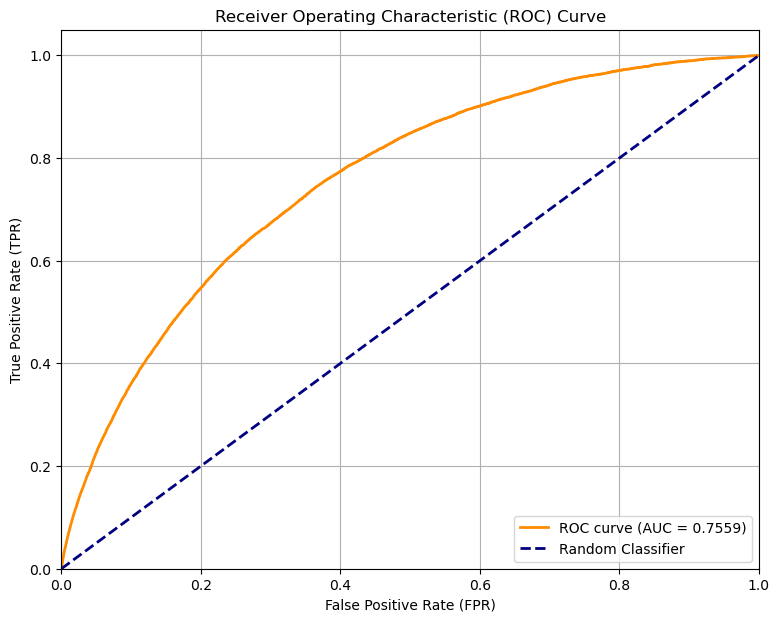

In [33]:
# --- 4. Построение ROC AUC кривой ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Значение ROC AUC на тестовой выборке: 0.7559


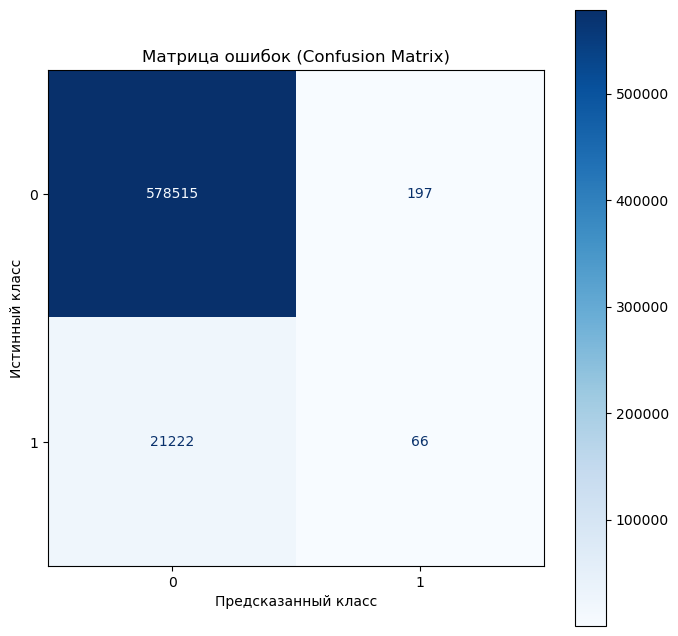


Матрица ошибок (Confusion Matrix):
 [[578515    197]
 [ 21222     66]]


In [34]:
print(f"Значение ROC AUC на тестовой выборке: {roc_auc:.4f}")

# --- 5. Построение матрицы ошибок (Confusion Matrix) ---
cm = confusion_matrix(y_test, y_pred)
# Создаем объект ConfusionMatrixDisplay для удобного отображения
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(8, 8))
# Отображаем матрицу ошибок на текущих осях
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title('Матрица ошибок (Confusion Matrix)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.grid(False) # Отключаем сетку для матрицы
plt.show()

print("\nМатрица ошибок (Confusion Matrix):\n", cm)

In [ ]:
#БУДЕМ ИСПОЛЬЗОАТЬ ПОДБОР ПО СЕТКЕ

In [54]:
# Разделение данных на признаки (X) и целевую переменную (y)
# Удаляем 'id', если он не является признаком, а просто идентификатором.
features_to_drop = ['target']
if 'id' in train_data.columns:
    features_to_drop.append('id')

X = train_data.drop(columns=features_to_drop)
y = train_data['target']

print(f"Размер X (признаков): {X.shape}")
print(f"Размер y (целевой переменной): {y.shape}")

Размер X (признаков): (3000000, 420)
Размер y (целевой переменной): (3000000,)


In [55]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Размер X_test: {X_test.shape}, y_test: {y_test.shape}")


Размер X_train: (2400000, 420), y_train: (2400000,)
Размер X_test: (600000, 420), y_test: (600000,)


In [56]:
# --- 1. Параметры модели CatBoost (базовые, не те, что подбираются) ---
base_tree_params = {
    "objective": "Logloss",
    "eval_metric": "AUC",
    "l2_leaf_reg": 0.5,
    "learning_rate": 0.6,
    "n_estimators": 1000,
    "early_stopping_rounds": 50
}

In [57]:
# --- 2. Определение сетки для подбора гиперпараметров ---
grid = {
    'l2_leaf_reg': [0.01, 0.1, 1, 10, 100, 110]
}


In [58]:
# --- 3. Инициализация модели и запуск grid_search ---
print("\nНачинаем подбор гиперпараметров CatBoost с помощью grid_search...")
print(f"Базовые параметры: {base_tree_params}")
print(f"Параметры для подбора (сетка): {grid}")

# Создаем экземпляр CatBoostClassifier с базовыми параметрами
model = CatBoostClassifier(**base_tree_params)

start_time = time.time() # Записываем время начала подбора



Начинаем подбор гиперпараметров CatBoost с помощью grid_search...
Базовые параметры: {'objective': 'Logloss', 'eval_metric': 'AUC', 'l2_leaf_reg': 0.5, 'learning_rate': 0.6, 'n_estimators': 1000, 'early_stopping_rounds': 50}
Параметры для подбора (сетка): {'l2_leaf_reg': [0.01, 0.1, 1, 10, 100, 110]}


In [59]:
# Запускаем grid_search
# cv - количество фолдов для кросс-валидации для каждого набора параметров
# refit=True - после завершения поиска, модель автоматически переобучится на всем X_train
#              с лучшими найденными параметрами. Это удобно, т.к. model_grid_search
#              сразу станет вашей обученной моделью.
# verbose=True - выводить информацию о ходе grid_search
model.grid_search(grid,
                  X=X_train,
                  y=y_train,
                  cv=3, # Рекомендуется использовать 3 или 5 фолдов для CV
                  refit=True,
                  plot=False, # Установите в True, если хотите видеть живой график в Jupyter Notebook
                  verbose=True) # Показывает прогресс поиска

end_time = time.time() # Записываем время окончания подбора
training_time = end_time - start_time

print(f"\nПодбор гиперпараметров и обучение лучшей модели завершено. Общее время: {training_time:.2f} секунд.")


0:	test: 0.5181398	best: 0.5181398 (0)	total: 510ms	remaining: 8m 29s
1:	test: 0.6577267	best: 0.6577267 (1)	total: 1.17s	remaining: 9m 44s
2:	test: 0.6982359	best: 0.6982359 (2)	total: 1.86s	remaining: 10m 19s
3:	test: 0.7125918	best: 0.7125918 (3)	total: 2.66s	remaining: 11m 3s
4:	test: 0.7194201	best: 0.7194201 (4)	total: 3.29s	remaining: 10m 53s
5:	test: 0.7239722	best: 0.7239722 (5)	total: 4.03s	remaining: 11m 6s
6:	test: 0.7271396	best: 0.7271396 (6)	total: 4.81s	remaining: 11m 22s
7:	test: 0.7305504	best: 0.7305504 (7)	total: 5.61s	remaining: 11m 36s
8:	test: 0.7324628	best: 0.7324628 (8)	total: 6.2s	remaining: 11m 23s
9:	test: 0.7337767	best: 0.7337767 (9)	total: 6.87s	remaining: 11m 19s
10:	test: 0.7356221	best: 0.7356221 (10)	total: 7.65s	remaining: 11m 27s
11:	test: 0.7361371	best: 0.7361371 (11)	total: 8.13s	remaining: 11m 9s
12:	test: 0.7371522	best: 0.7371522 (12)	total: 8.84s	remaining: 11m 11s
13:	test: 0.7382132	best: 0.7382132 (13)	total: 9.45s	remaining: 11m 5s
14:	t

114:	test: 0.7510975	best: 0.7510975 (114)	total: 1m 6s	remaining: 8m 29s
115:	test: 0.7510461	best: 0.7510975 (114)	total: 1m 6s	remaining: 8m 28s
116:	test: 0.7509849	best: 0.7510975 (114)	total: 1m 7s	remaining: 8m 26s
117:	test: 0.7510353	best: 0.7510975 (114)	total: 1m 7s	remaining: 8m 25s
118:	test: 0.7510869	best: 0.7510975 (114)	total: 1m 8s	remaining: 8m 24s
119:	test: 0.7510881	best: 0.7510975 (114)	total: 1m 8s	remaining: 8m 24s
120:	test: 0.7510265	best: 0.7510975 (114)	total: 1m 9s	remaining: 8m 22s
121:	test: 0.7510455	best: 0.7510975 (114)	total: 1m 9s	remaining: 8m 21s
122:	test: 0.7510303	best: 0.7510975 (114)	total: 1m 10s	remaining: 8m 21s
123:	test: 0.7509664	best: 0.7510975 (114)	total: 1m 10s	remaining: 8m 21s
124:	test: 0.7509252	best: 0.7510975 (114)	total: 1m 11s	remaining: 8m 20s
125:	test: 0.7510981	best: 0.7510981 (125)	total: 1m 11s	remaining: 8m 19s
126:	test: 0.7510622	best: 0.7510981 (125)	total: 1m 12s	remaining: 8m 18s
127:	test: 0.7510856	best: 0.7510

39:	test: 0.7486867	best: 0.7486867 (39)	total: 24.9s	remaining: 9m 58s
40:	test: 0.7490535	best: 0.7490535 (40)	total: 25.7s	remaining: 10m
41:	test: 0.7492349	best: 0.7492349 (41)	total: 26.2s	remaining: 9m 57s
42:	test: 0.7493098	best: 0.7493098 (42)	total: 26.7s	remaining: 9m 54s
43:	test: 0.7493345	best: 0.7493345 (43)	total: 27.2s	remaining: 9m 51s
44:	test: 0.7494013	best: 0.7494013 (44)	total: 27.8s	remaining: 9m 48s
45:	test: 0.7495751	best: 0.7495751 (45)	total: 28.5s	remaining: 9m 51s
46:	test: 0.7495504	best: 0.7495751 (45)	total: 29s	remaining: 9m 48s
47:	test: 0.7497479	best: 0.7497479 (47)	total: 29.6s	remaining: 9m 47s
48:	test: 0.7499634	best: 0.7499634 (48)	total: 30.4s	remaining: 9m 49s
49:	test: 0.7499882	best: 0.7499882 (49)	total: 30.8s	remaining: 9m 44s
50:	test: 0.7500199	best: 0.7500199 (50)	total: 31.3s	remaining: 9m 42s
51:	test: 0.7500890	best: 0.7500890 (51)	total: 31.8s	remaining: 9m 40s
52:	test: 0.7500055	best: 0.7500890 (51)	total: 32.7s	remaining: 9m 4

5:	test: 0.7247935	best: 0.7247935 (5)	total: 4.15s	remaining: 11m 27s
6:	test: 0.7278024	best: 0.7278024 (6)	total: 4.91s	remaining: 11m 36s
7:	test: 0.7306754	best: 0.7306754 (7)	total: 5.61s	remaining: 11m 35s
8:	test: 0.7324607	best: 0.7324607 (8)	total: 6.24s	remaining: 11m 27s
9:	test: 0.7332532	best: 0.7332532 (9)	total: 6.79s	remaining: 11m 11s
10:	test: 0.7339680	best: 0.7339680 (10)	total: 7.35s	remaining: 11m
11:	test: 0.7354298	best: 0.7354298 (11)	total: 8.01s	remaining: 10m 59s
12:	test: 0.7364625	best: 0.7364625 (12)	total: 8.66s	remaining: 10m 57s
13:	test: 0.7376348	best: 0.7376348 (13)	total: 9.42s	remaining: 11m 3s
14:	test: 0.7383212	best: 0.7383212 (14)	total: 10.1s	remaining: 11m 4s
15:	test: 0.7390687	best: 0.7390687 (15)	total: 10.7s	remaining: 11m
16:	test: 0.7393916	best: 0.7393916 (16)	total: 11.3s	remaining: 10m 51s
17:	test: 0.7398681	best: 0.7398681 (17)	total: 12.1s	remaining: 10m 58s
18:	test: 0.7406334	best: 0.7406334 (18)	total: 12.7s	remaining: 10m 55

119:	test: 0.7515757	best: 0.7517539 (109)	total: 1m 11s	remaining: 8m 42s
120:	test: 0.7516220	best: 0.7517539 (109)	total: 1m 11s	remaining: 8m 41s
121:	test: 0.7516396	best: 0.7517539 (109)	total: 1m 12s	remaining: 8m 40s
122:	test: 0.7516697	best: 0.7517539 (109)	total: 1m 12s	remaining: 8m 40s
123:	test: 0.7516354	best: 0.7517539 (109)	total: 1m 13s	remaining: 8m 39s
124:	test: 0.7516277	best: 0.7517539 (109)	total: 1m 13s	remaining: 8m 37s
125:	test: 0.7516549	best: 0.7517539 (109)	total: 1m 14s	remaining: 8m 37s
126:	test: 0.7516179	best: 0.7517539 (109)	total: 1m 15s	remaining: 8m 36s
127:	test: 0.7516149	best: 0.7517539 (109)	total: 1m 15s	remaining: 8m 35s
128:	test: 0.7516461	best: 0.7517539 (109)	total: 1m 16s	remaining: 8m 34s
129:	test: 0.7516616	best: 0.7517539 (109)	total: 1m 16s	remaining: 8m 33s
130:	test: 0.7517917	best: 0.7517917 (130)	total: 1m 17s	remaining: 8m 33s
131:	test: 0.7518410	best: 0.7518410 (131)	total: 1m 17s	remaining: 8m 31s
132:	test: 0.7518687	best

43:	test: 0.7490815	best: 0.7490815 (43)	total: 27.3s	remaining: 9m 54s
44:	test: 0.7491035	best: 0.7491035 (44)	total: 27.9s	remaining: 9m 52s
45:	test: 0.7496164	best: 0.7496164 (45)	total: 28.5s	remaining: 9m 51s
46:	test: 0.7498845	best: 0.7498845 (46)	total: 29.1s	remaining: 9m 50s
47:	test: 0.7499170	best: 0.7499170 (47)	total: 29.7s	remaining: 9m 48s
48:	test: 0.7500212	best: 0.7500212 (48)	total: 30.3s	remaining: 9m 48s
49:	test: 0.7503270	best: 0.7503270 (49)	total: 31s	remaining: 9m 49s
50:	test: 0.7505201	best: 0.7505201 (50)	total: 31.8s	remaining: 9m 51s
51:	test: 0.7506033	best: 0.7506033 (51)	total: 32.4s	remaining: 9m 50s
52:	test: 0.7506297	best: 0.7506297 (52)	total: 32.8s	remaining: 9m 46s
53:	test: 0.7506434	best: 0.7506434 (53)	total: 33.4s	remaining: 9m 45s
54:	test: 0.7506741	best: 0.7506741 (54)	total: 33.9s	remaining: 9m 42s
55:	test: 0.7509390	best: 0.7509390 (55)	total: 34.6s	remaining: 9m 44s
56:	test: 0.7510397	best: 0.7510397 (56)	total: 35.4s	remaining: 9

156:	test: 0.7532926	best: 0.7533155 (140)	total: 1m 33s	remaining: 8m 20s
157:	test: 0.7532927	best: 0.7533155 (140)	total: 1m 33s	remaining: 8m 18s
158:	test: 0.7532731	best: 0.7533155 (140)	total: 1m 34s	remaining: 8m 18s
159:	test: 0.7532151	best: 0.7533155 (140)	total: 1m 34s	remaining: 8m 16s
160:	test: 0.7532097	best: 0.7533155 (140)	total: 1m 35s	remaining: 8m 15s
161:	test: 0.7532122	best: 0.7533155 (140)	total: 1m 35s	remaining: 8m 14s
162:	test: 0.7532199	best: 0.7533155 (140)	total: 1m 36s	remaining: 8m 13s
163:	test: 0.7531944	best: 0.7533155 (140)	total: 1m 36s	remaining: 8m 12s
164:	test: 0.7531822	best: 0.7533155 (140)	total: 1m 37s	remaining: 8m 12s
165:	test: 0.7531823	best: 0.7533155 (140)	total: 1m 37s	remaining: 8m 11s
166:	test: 0.7531457	best: 0.7533155 (140)	total: 1m 38s	remaining: 8m 11s
167:	test: 0.7532881	best: 0.7533155 (140)	total: 1m 39s	remaining: 8m 10s
168:	test: 0.7535074	best: 0.7535074 (168)	total: 1m 39s	remaining: 8m 10s
169:	test: 0.7535739	best

12:	test: 0.7377836	best: 0.7377836 (12)	total: 9.02s	remaining: 11m 24s
13:	test: 0.7384943	best: 0.7384943 (13)	total: 9.61s	remaining: 11m 16s
14:	test: 0.7392872	best: 0.7392872 (14)	total: 10.3s	remaining: 11m 13s
15:	test: 0.7400353	best: 0.7400353 (15)	total: 10.8s	remaining: 11m 5s
16:	test: 0.7400294	best: 0.7400353 (15)	total: 11.2s	remaining: 10m 49s
17:	test: 0.7408069	best: 0.7408069 (17)	total: 11.8s	remaining: 10m 42s
18:	test: 0.7413656	best: 0.7413656 (18)	total: 12.5s	remaining: 10m 42s
19:	test: 0.7422567	best: 0.7422567 (19)	total: 13.2s	remaining: 10m 46s
20:	test: 0.7429054	best: 0.7429054 (20)	total: 14s	remaining: 10m 51s
21:	test: 0.7433553	best: 0.7433553 (21)	total: 14.6s	remaining: 10m 50s
22:	test: 0.7438057	best: 0.7438057 (22)	total: 15.4s	remaining: 10m 52s
23:	test: 0.7440016	best: 0.7440016 (23)	total: 15.8s	remaining: 10m 42s
24:	test: 0.7445015	best: 0.7445015 (24)	total: 16.5s	remaining: 10m 43s
25:	test: 0.7446254	best: 0.7446254 (25)	total: 17.1s	

126:	test: 0.7529323	best: 0.7529776 (123)	total: 1m 10s	remaining: 8m 1s
127:	test: 0.7529331	best: 0.7529776 (123)	total: 1m 10s	remaining: 8m
128:	test: 0.7529851	best: 0.7529851 (128)	total: 1m 10s	remaining: 7m 59s
129:	test: 0.7530025	best: 0.7530025 (129)	total: 1m 11s	remaining: 7m 58s
130:	test: 0.7530024	best: 0.7530025 (129)	total: 1m 11s	remaining: 7m 56s
131:	test: 0.7530017	best: 0.7530025 (129)	total: 1m 12s	remaining: 7m 55s
132:	test: 0.7530053	best: 0.7530053 (132)	total: 1m 12s	remaining: 7m 54s
133:	test: 0.7529951	best: 0.7530053 (132)	total: 1m 13s	remaining: 7m 54s
134:	test: 0.7529948	best: 0.7530053 (132)	total: 1m 13s	remaining: 7m 52s
135:	test: 0.7529945	best: 0.7530053 (132)	total: 1m 14s	remaining: 7m 51s
136:	test: 0.7533222	best: 0.7533222 (136)	total: 1m 14s	remaining: 7m 51s
137:	test: 0.7533043	best: 0.7533222 (136)	total: 1m 15s	remaining: 7m 50s
138:	test: 0.7533046	best: 0.7533222 (136)	total: 1m 15s	remaining: 7m 49s
139:	test: 0.7533473	best: 0.7

236:	test: 0.7544810	best: 0.7545370 (189)	total: 2m 5s	remaining: 6m 43s
237:	test: 0.7544809	best: 0.7545370 (189)	total: 2m 5s	remaining: 6m 42s
238:	test: 0.7544796	best: 0.7545370 (189)	total: 2m 6s	remaining: 6m 42s
239:	test: 0.7544796	best: 0.7545370 (189)	total: 2m 6s	remaining: 6m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7545370191
bestIteration = 189

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
4:	loss: 0.7545370	best: 0.7545370 (4)	total: 9m 33s	remaining: 1m 54s
0:	test: 0.5181394	best: 0.5181394 (0)	total: 530ms	remaining: 8m 49s
1:	test: 0.6729957	best: 0.6729957 (1)	total: 1.21s	remaining: 10m 3s
2:	test: 0.7047391	best: 0.7047391 (2)	total: 1.96s	remaining: 10m 52s
3:	test: 0.7150015	best: 0.7150015 (3)	total: 2.58s	remaining: 10m 41s
4:	test: 0.7210178	best: 0.7210178 (4)	total: 3.31s	remaining: 10m 59s
5:	test: 0.7269587	best: 0.7269587 (5)	total: 

106:	test: 0.7528350	best: 0.7528361 (101)	total: 59s	remaining: 8m 12s
107:	test: 0.7528351	best: 0.7528361 (101)	total: 59.5s	remaining: 8m 11s
108:	test: 0.7528350	best: 0.7528361 (101)	total: 59.8s	remaining: 8m 9s
109:	test: 0.7528200	best: 0.7528361 (101)	total: 1m	remaining: 8m 7s
110:	test: 0.7529643	best: 0.7529643 (110)	total: 1m	remaining: 8m 7s
111:	test: 0.7529671	best: 0.7529671 (111)	total: 1m 1s	remaining: 8m 6s
112:	test: 0.7530811	best: 0.7530811 (112)	total: 1m 2s	remaining: 8m 7s
113:	test: 0.7530817	best: 0.7530817 (113)	total: 1m 2s	remaining: 8m 5s
114:	test: 0.7531059	best: 0.7531059 (114)	total: 1m 2s	remaining: 8m 4s
115:	test: 0.7531463	best: 0.7531463 (115)	total: 1m 3s	remaining: 8m 4s
116:	test: 0.7531939	best: 0.7531939 (116)	total: 1m 4s	remaining: 8m 5s
117:	test: 0.7533021	best: 0.7533021 (117)	total: 1m 5s	remaining: 8m 6s
118:	test: 0.7533664	best: 0.7533664 (118)	total: 1m 5s	remaining: 8m 6s
119:	test: 0.7534019	best: 0.7534019 (119)	total: 1m 6s	r

217:	test: 0.7545842	best: 0.7546182 (187)	total: 1m 53s	remaining: 6m 48s
218:	test: 0.7545839	best: 0.7546182 (187)	total: 1m 54s	remaining: 6m 47s
219:	test: 0.7545841	best: 0.7546182 (187)	total: 1m 54s	remaining: 6m 46s
220:	test: 0.7545838	best: 0.7546182 (187)	total: 1m 55s	remaining: 6m 46s
221:	test: 0.7545839	best: 0.7546182 (187)	total: 1m 55s	remaining: 6m 45s
222:	test: 0.7545859	best: 0.7546182 (187)	total: 1m 56s	remaining: 6m 45s
223:	test: 0.7545858	best: 0.7546182 (187)	total: 1m 56s	remaining: 6m 43s
224:	test: 0.7545591	best: 0.7546182 (187)	total: 1m 57s	remaining: 6m 43s
225:	test: 0.7545560	best: 0.7546182 (187)	total: 1m 57s	remaining: 6m 42s
226:	test: 0.7546285	best: 0.7546285 (226)	total: 1m 58s	remaining: 6m 42s
227:	test: 0.7546374	best: 0.7546374 (227)	total: 1m 58s	remaining: 6m 42s
228:	test: 0.7546373	best: 0.7546374 (227)	total: 1m 59s	remaining: 6m 41s
229:	test: 0.7546371	best: 0.7546374 (227)	total: 1m 59s	remaining: 6m 40s
230:	test: 0.7546371	best

327:	test: 0.7548435	best: 0.7548435 (327)	total: 2m 49s	remaining: 5m 48s
328:	test: 0.7549184	best: 0.7549184 (328)	total: 2m 50s	remaining: 5m 47s
329:	test: 0.7548924	best: 0.7549184 (328)	total: 2m 51s	remaining: 5m 47s
330:	test: 0.7548925	best: 0.7549184 (328)	total: 2m 51s	remaining: 5m 46s
331:	test: 0.7548923	best: 0.7549184 (328)	total: 2m 51s	remaining: 5m 46s
332:	test: 0.7548927	best: 0.7549184 (328)	total: 2m 52s	remaining: 5m 45s
333:	test: 0.7548927	best: 0.7549184 (328)	total: 2m 52s	remaining: 5m 44s
334:	test: 0.7548924	best: 0.7549184 (328)	total: 2m 53s	remaining: 5m 43s
335:	test: 0.7548921	best: 0.7549184 (328)	total: 2m 53s	remaining: 5m 42s
336:	test: 0.7548919	best: 0.7549184 (328)	total: 2m 53s	remaining: 5m 42s
337:	test: 0.7548918	best: 0.7549184 (328)	total: 2m 54s	remaining: 5m 41s
338:	test: 0.7548913	best: 0.7549184 (328)	total: 2m 54s	remaining: 5m 40s
339:	test: 0.7548916	best: 0.7549184 (328)	total: 2m 55s	remaining: 5m 40s
340:	test: 0.7548918	best

56:	test: 0.7519801	best: 0.7519805 (54)	total: 28.6s	remaining: 7m 53s
57:	test: 0.7519807	best: 0.7519807 (57)	total: 29s	remaining: 7m 50s
58:	test: 0.7519808	best: 0.7519808 (58)	total: 29.3s	remaining: 7m 48s
59:	test: 0.7522538	best: 0.7522538 (59)	total: 29.9s	remaining: 7m 48s
60:	test: 0.7522671	best: 0.7522671 (60)	total: 30.4s	remaining: 7m 47s
61:	test: 0.7522671	best: 0.7522671 (61)	total: 30.8s	remaining: 7m 45s
62:	test: 0.7522673	best: 0.7522673 (62)	total: 31.1s	remaining: 7m 42s
63:	test: 0.7522678	best: 0.7522678 (63)	total: 31.5s	remaining: 7m 40s
64:	test: 0.7522645	best: 0.7522678 (63)	total: 31.8s	remaining: 7m 38s
65:	test: 0.7522667	best: 0.7522678 (63)	total: 32.3s	remaining: 7m 37s
66:	test: 0.7524159	best: 0.7524159 (66)	total: 33s	remaining: 7m 39s
67:	test: 0.7525240	best: 0.7525240 (67)	total: 33.6s	remaining: 7m 40s
68:	test: 0.7526598	best: 0.7526598 (68)	total: 34.2s	remaining: 7m 41s
69:	test: 0.7526576	best: 0.7526598 (68)	total: 34.7s	remaining: 7m 

169:	test: 0.7553921	best: 0.7554583 (167)	total: 1m 20s	remaining: 6m 31s
170:	test: 0.7553921	best: 0.7554583 (167)	total: 1m 20s	remaining: 6m 30s
171:	test: 0.7554728	best: 0.7554728 (171)	total: 1m 21s	remaining: 6m 30s
172:	test: 0.7554332	best: 0.7554728 (171)	total: 1m 21s	remaining: 6m 30s
173:	test: 0.7554319	best: 0.7554728 (171)	total: 1m 22s	remaining: 6m 29s
174:	test: 0.7554318	best: 0.7554728 (171)	total: 1m 22s	remaining: 6m 28s
175:	test: 0.7554313	best: 0.7554728 (171)	total: 1m 22s	remaining: 6m 27s
176:	test: 0.7554313	best: 0.7554728 (171)	total: 1m 23s	remaining: 6m 26s
177:	test: 0.7554310	best: 0.7554728 (171)	total: 1m 23s	remaining: 6m 25s
178:	test: 0.7554320	best: 0.7554728 (171)	total: 1m 23s	remaining: 6m 24s
179:	test: 0.7554319	best: 0.7554728 (171)	total: 1m 24s	remaining: 6m 23s
180:	test: 0.7554354	best: 0.7554728 (171)	total: 1m 24s	remaining: 6m 22s
181:	test: 0.7554375	best: 0.7554728 (171)	total: 1m 25s	remaining: 6m 22s
182:	test: 0.7554992	best

280:	test: 0.7561523	best: 0.7562832 (259)	total: 2m 11s	remaining: 5m 36s
281:	test: 0.7561440	best: 0.7562832 (259)	total: 2m 11s	remaining: 5m 36s
282:	test: 0.7561237	best: 0.7562832 (259)	total: 2m 12s	remaining: 5m 35s
283:	test: 0.7561861	best: 0.7562832 (259)	total: 2m 13s	remaining: 5m 35s
284:	test: 0.7561864	best: 0.7562832 (259)	total: 2m 13s	remaining: 5m 34s
285:	test: 0.7561864	best: 0.7562832 (259)	total: 2m 13s	remaining: 5m 34s
286:	test: 0.7562712	best: 0.7562832 (259)	total: 2m 14s	remaining: 5m 33s
287:	test: 0.7563104	best: 0.7563104 (287)	total: 2m 14s	remaining: 5m 33s
288:	test: 0.7563188	best: 0.7563188 (288)	total: 2m 15s	remaining: 5m 32s
289:	test: 0.7562989	best: 0.7563188 (288)	total: 2m 15s	remaining: 5m 32s
290:	test: 0.7563878	best: 0.7563878 (290)	total: 2m 16s	remaining: 5m 32s
291:	test: 0.7563893	best: 0.7563893 (291)	total: 2m 16s	remaining: 5m 31s
292:	test: 0.7563713	best: 0.7563893 (291)	total: 2m 17s	remaining: 5m 31s
293:	test: 0.7563804	best

49:	test: 0.7518115	best: 0.7518117 (48)	total: 25.9s	remaining: 8m 11s
50:	test: 0.7517860	best: 0.7518117 (48)	total: 26.5s	remaining: 8m 12s
51:	test: 0.7518889	best: 0.7518889 (51)	total: 26.9s	remaining: 8m 11s
52:	test: 0.7518909	best: 0.7518909 (52)	total: 27.4s	remaining: 8m 10s
53:	test: 0.7518913	best: 0.7518913 (53)	total: 27.8s	remaining: 8m 6s
54:	test: 0.7519937	best: 0.7519937 (54)	total: 28.3s	remaining: 8m 6s
55:	test: 0.7519935	best: 0.7519937 (54)	total: 28.6s	remaining: 8m 2s
56:	test: 0.7519934	best: 0.7519937 (54)	total: 29s	remaining: 7m 59s
57:	test: 0.7519933	best: 0.7519937 (54)	total: 29.4s	remaining: 7m 56s
58:	test: 0.7520597	best: 0.7520597 (58)	total: 30s	remaining: 7m 57s
59:	test: 0.7520855	best: 0.7520855 (59)	total: 30.4s	remaining: 7m 55s
60:	test: 0.7523723	best: 0.7523723 (60)	total: 31s	remaining: 7m 57s
61:	test: 0.7524487	best: 0.7524487 (61)	total: 31.5s	remaining: 7m 57s
62:	test: 0.7524516	best: 0.7524516 (62)	total: 31.9s	remaining: 7m 54s
6

162:	test: 0.7548314	best: 0.7548664 (161)	total: 1m 17s	remaining: 6m 38s
163:	test: 0.7548357	best: 0.7548664 (161)	total: 1m 18s	remaining: 6m 37s
164:	test: 0.7548356	best: 0.7548664 (161)	total: 1m 18s	remaining: 6m 36s
165:	test: 0.7548358	best: 0.7548664 (161)	total: 1m 18s	remaining: 6m 35s
166:	test: 0.7548012	best: 0.7548664 (161)	total: 1m 19s	remaining: 6m 35s
167:	test: 0.7548551	best: 0.7548664 (161)	total: 1m 19s	remaining: 6m 35s
168:	test: 0.7548569	best: 0.7548664 (161)	total: 1m 20s	remaining: 6m 34s
169:	test: 0.7548176	best: 0.7548664 (161)	total: 1m 20s	remaining: 6m 34s
170:	test: 0.7548211	best: 0.7548664 (161)	total: 1m 21s	remaining: 6m 33s
171:	test: 0.7548207	best: 0.7548664 (161)	total: 1m 21s	remaining: 6m 33s
172:	test: 0.7548188	best: 0.7548664 (161)	total: 1m 22s	remaining: 6m 32s
173:	test: 0.7549154	best: 0.7549154 (173)	total: 1m 22s	remaining: 6m 32s
174:	test: 0.7548955	best: 0.7549154 (173)	total: 1m 23s	remaining: 6m 32s
175:	test: 0.7548952	best

272:	test: 0.7552864	best: 0.7553588 (260)	total: 2m 7s	remaining: 5m 38s
273:	test: 0.7551947	best: 0.7553588 (260)	total: 2m 7s	remaining: 5m 38s
274:	test: 0.7551945	best: 0.7553588 (260)	total: 2m 8s	remaining: 5m 38s
275:	test: 0.7551864	best: 0.7553588 (260)	total: 2m 8s	remaining: 5m 37s
276:	test: 0.7551860	best: 0.7553588 (260)	total: 2m 9s	remaining: 5m 37s
277:	test: 0.7551856	best: 0.7553588 (260)	total: 2m 9s	remaining: 5m 36s
278:	test: 0.7551849	best: 0.7553588 (260)	total: 2m 9s	remaining: 5m 35s
279:	test: 0.7551839	best: 0.7553588 (260)	total: 2m 10s	remaining: 5m 35s
280:	test: 0.7551883	best: 0.7553588 (260)	total: 2m 10s	remaining: 5m 34s
281:	test: 0.7551951	best: 0.7553588 (260)	total: 2m 11s	remaining: 5m 33s
282:	test: 0.7551944	best: 0.7553588 (260)	total: 2m 11s	remaining: 5m 33s
283:	test: 0.7552148	best: 0.7553588 (260)	total: 2m 12s	remaining: 5m 33s
284:	test: 0.7551789	best: 0.7553588 (260)	total: 2m 12s	remaining: 5m 32s
285:	test: 0.7551791	best: 0.755

74:	test: 0.7506485	best: 0.7506485 (74)	total: 37.2s	remaining: 7m 38s
75:	test: 0.7511055	best: 0.7511055 (75)	total: 37.8s	remaining: 7m 39s
76:	test: 0.7511799	best: 0.7511799 (76)	total: 38.2s	remaining: 7m 38s
77:	test: 0.7512099	best: 0.7512099 (77)	total: 38.8s	remaining: 7m 38s
78:	test: 0.7511767	best: 0.7512099 (77)	total: 39.3s	remaining: 7m 38s
79:	test: 0.7511771	best: 0.7512099 (77)	total: 39.9s	remaining: 7m 38s
80:	test: 0.7511740	best: 0.7512099 (77)	total: 40.3s	remaining: 7m 37s
81:	test: 0.7511740	best: 0.7512099 (77)	total: 40.6s	remaining: 7m 35s
82:	test: 0.7511733	best: 0.7512099 (77)	total: 41s	remaining: 7m 33s
83:	test: 0.7512702	best: 0.7512702 (83)	total: 41.7s	remaining: 7m 34s
84:	test: 0.7512702	best: 0.7512702 (83)	total: 42.1s	remaining: 7m 33s
85:	test: 0.7512616	best: 0.7512702 (83)	total: 42.7s	remaining: 7m 33s
86:	test: 0.7512618	best: 0.7512702 (83)	total: 43s	remaining: 7m 31s
87:	test: 0.7512652	best: 0.7512702 (83)	total: 43.5s	remaining: 7m 

186:	test: 0.7526650	best: 0.7527203 (171)	total: 1m 25s	remaining: 6m 13s
187:	test: 0.7526652	best: 0.7527203 (171)	total: 1m 26s	remaining: 6m 12s
188:	test: 0.7526651	best: 0.7527203 (171)	total: 1m 26s	remaining: 6m 11s
189:	test: 0.7526654	best: 0.7527203 (171)	total: 1m 27s	remaining: 6m 11s
190:	test: 0.7526655	best: 0.7527203 (171)	total: 1m 27s	remaining: 6m 10s
191:	test: 0.7526654	best: 0.7527203 (171)	total: 1m 27s	remaining: 6m 9s
192:	test: 0.7526655	best: 0.7527203 (171)	total: 1m 28s	remaining: 6m 8s
193:	test: 0.7527649	best: 0.7527649 (193)	total: 1m 28s	remaining: 6m 8s
194:	test: 0.7527953	best: 0.7527953 (194)	total: 1m 29s	remaining: 6m 8s
195:	test: 0.7527956	best: 0.7527956 (195)	total: 1m 29s	remaining: 6m 7s
196:	test: 0.7527956	best: 0.7527956 (195)	total: 1m 29s	remaining: 6m 6s
197:	test: 0.7527955	best: 0.7527956 (195)	total: 1m 30s	remaining: 6m 5s
198:	test: 0.7527945	best: 0.7527956 (195)	total: 1m 30s	remaining: 6m 5s
199:	test: 0.7527971	best: 0.7527

297:	test: 0.7538691	best: 0.7538691 (297)	total: 2m 15s	remaining: 5m 18s
298:	test: 0.7538690	best: 0.7538691 (297)	total: 2m 15s	remaining: 5m 18s
299:	test: 0.7538725	best: 0.7538725 (299)	total: 2m 16s	remaining: 5m 17s
300:	test: 0.7538732	best: 0.7538732 (300)	total: 2m 16s	remaining: 5m 17s
301:	test: 0.7538731	best: 0.7538732 (300)	total: 2m 16s	remaining: 5m 16s
302:	test: 0.7538730	best: 0.7538732 (300)	total: 2m 17s	remaining: 5m 15s
303:	test: 0.7538738	best: 0.7538738 (303)	total: 2m 17s	remaining: 5m 15s
304:	test: 0.7538143	best: 0.7538738 (303)	total: 2m 18s	remaining: 5m 14s
305:	test: 0.7538144	best: 0.7538738 (303)	total: 2m 18s	remaining: 5m 13s
306:	test: 0.7538145	best: 0.7538738 (303)	total: 2m 18s	remaining: 5m 13s
307:	test: 0.7538145	best: 0.7538738 (303)	total: 2m 19s	remaining: 5m 12s
308:	test: 0.7538496	best: 0.7538738 (303)	total: 2m 19s	remaining: 5m 12s
309:	test: 0.7538729	best: 0.7538738 (303)	total: 2m 20s	remaining: 5m 11s
310:	test: 0.7538727	best

407:	test: 0.7540120	best: 0.7540208 (379)	total: 3m 2s	remaining: 4m 24s
408:	test: 0.7540118	best: 0.7540208 (379)	total: 3m 2s	remaining: 4m 24s
409:	test: 0.7540122	best: 0.7540208 (379)	total: 3m 3s	remaining: 4m 23s
410:	test: 0.7539934	best: 0.7540208 (379)	total: 3m 3s	remaining: 4m 23s
411:	test: 0.7539821	best: 0.7540208 (379)	total: 3m 4s	remaining: 4m 23s
412:	test: 0.7539822	best: 0.7540208 (379)	total: 3m 4s	remaining: 4m 22s
413:	test: 0.7539822	best: 0.7540208 (379)	total: 3m 5s	remaining: 4m 21s
414:	test: 0.7539747	best: 0.7540208 (379)	total: 3m 5s	remaining: 4m 21s
415:	test: 0.7539750	best: 0.7540208 (379)	total: 3m 5s	remaining: 4m 20s
416:	test: 0.7539960	best: 0.7540208 (379)	total: 3m 6s	remaining: 4m 20s
417:	test: 0.7539941	best: 0.7540208 (379)	total: 3m 6s	remaining: 4m 20s
418:	test: 0.7539941	best: 0.7540208 (379)	total: 3m 7s	remaining: 4m 19s
419:	test: 0.7539945	best: 0.7540208 (379)	total: 3m 7s	remaining: 4m 19s
420:	test: 0.7539949	best: 0.7540208 (

In [60]:
# --- 4. Проверка лучших найденных параметров ---
print("\nЛучшие найденные параметры:")
print(model.get_params())


Лучшие найденные параметры:
{'learning_rate': 0.6, 'l2_leaf_reg': 110, 'eval_metric': 'AUC', 'n_estimators': 1000, 'objective': 'Logloss', 'early_stopping_rounds': 50}


In [61]:
# --- 5. Прогнозирование на тестовой выборке (с лучшей моделью) ---
print("\nВыполняем предсказания на тестовой выборке...")
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)


Выполняем предсказания на тестовой выборке...


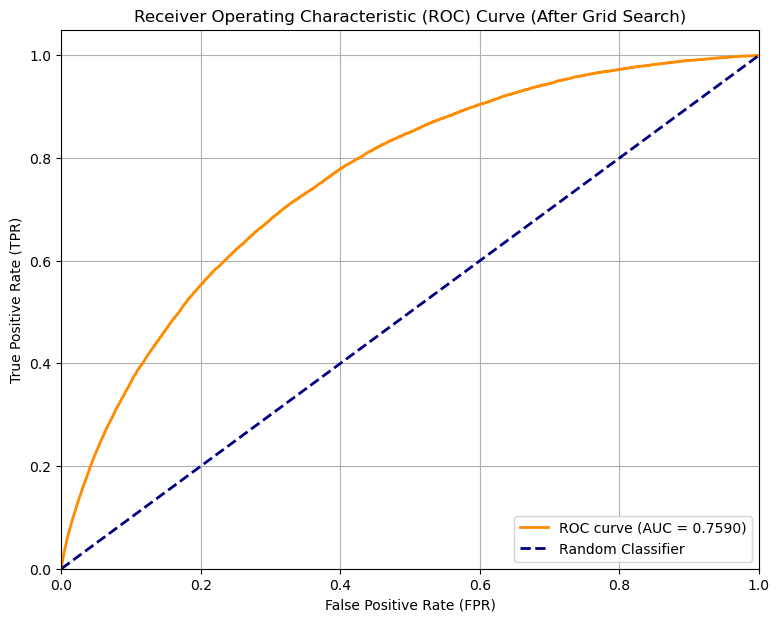

Значение ROC AUC на тестовой выборке: 0.7590


In [62]:
# --- 6. Построение ROC AUC кривой ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (After Grid Search)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Значение ROC AUC на тестовой выборке: {roc_auc:.4f}")


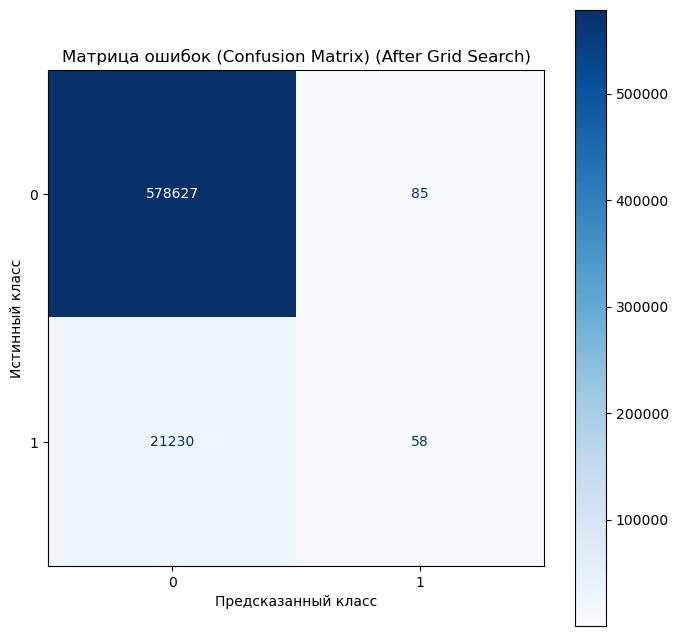


Матрица ошибок (Confusion Matrix):
 [[578627     85]
 [ 21230     58]]


In [63]:
# --- 7. Построение матрицы ошибок (Confusion Matrix) ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title('Матрица ошибок (Confusion Matrix) (After Grid Search)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.grid(False)
plt.show()

print("\nМатрица ошибок (Confusion Matrix):\n", cm)

In [ ]:
# ПОСТРОИМ МОДЕЛЬ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

In [66]:
# Разделение данных на признаки (X) и целевую переменную (y)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler # Для масштабирования признаков
features_to_drop = ['target']
if 'id' in train_data.columns:
    features_to_drop.append('id')

X = train_data.drop(columns=features_to_drop)
y = train_data['target']

# --- КЛЮЧЕВОЕ ИЗМЕНЕНИЕ 1: Приведение всех признаков к float32 ---
print(f"Исходный тип данных признаков: {X.dtypes.iloc[0]}")
X = X.astype(np.float32)
print(f"Новый тип данных признаков: {X.dtypes.iloc[0]} (уменьшено для экономии памяти)")

print(f"Размер X (признаков): {X.shape}")
print(f"Размер y (целевой переменной): {y.shape}")

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Размер X_test: {X_test.shape}, y_test: {y_test.shape}")


Исходный тип данных признаков: int8
Новый тип данных признаков: float32 (уменьшено для экономии памяти)
Размер X (признаков): (3000000, 420)
Размер y (целевой переменной): (3000000,)
Размер X_train: (2400000, 420), y_train: (2400000,)
Размер X_test: (600000, 420), y_test: (600000,)


In [67]:
# --- 2. Масштабирование признаков ---
print("\nВыполняем масштабирование признаков (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Масштабирование завершено.")



Выполняем масштабирование признаков (StandardScaler)...
Масштабирование завершено.


In [68]:
# Преобразуем обратно в DataFrame, чтобы сохранить имена колонок (необязательно, но полезно для отладки)
# и явно убедимся, что тип данных float32
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index).astype(np.float32)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index).astype(np.float32)
print(f"Тип данных масштабированных признаков: {X_train_scaled.dtypes.iloc[0]}")

Тип данных масштабированных признаков: float32


In [69]:
# --- КЛЮЧЕВОЕ ИЗМЕНЕНИЕ 2: Создание подвыборки для GridSearchCV ---
# Если у вас 3М записей, `GridSearchCV` на всех данных будет очень медленным и может
# все равно вызвать MemoryError из-за множества копий.
# Обучение на подвыборке для поиска лучших параметров - это стандартная практика.
# Финальную модель можно потом обучить на всем X_train_scaled.
subset_ratio = 0.1 # Использовать 10% обучающих данных для Grid Search
# Вы можете настроить этот процент в зависимости от доступной памяти и желаемой точности подбора.
# Если 0.1 все еще вызывает ошибку, попробуйте 0.05 или 0.02.

print(f"\nСоздаем подвыборку ({subset_ratio*100:.0f}%) обучающих данных для Grid Search...")
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train_scaled, y_train, test_size=(1-subset_ratio), random_state=42, stratify=y_train
)
print(f"Размер X_train_subset для Grid Search: {X_train_subset.shape}")


Создаем подвыборку (10%) обучающих данных для Grid Search...
Размер X_train_subset для Grid Search: (240000, 420)


In [70]:
# --- 2. Определение сетки для подбора гиперпараметров ---
# Для логистической регрессии с большим объемом данных:
# C: Инверсия силы регуляризации. Меньше C -> сильнее регуляризация.
# penalty: 'l1', 'l2', 'elasticnet', 'none'
# solver: Алгоритм оптимизации.
#   'liblinear' - хороший выбор для небольших данных, поддерживает L1/L2.
#   'saga' - поддерживает L1, L2, elasticnet и 'none'. Хорошо для больших данных.
#   'lbfgs' - по умолчанию, не поддерживает L1.
#   'newton-cg', 'sag' - поддерживают L2 и 'none'.
#   'newton-cholesky' - L2, 'none'.
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0], # Пример значений C. Можно добавить 0.01, 100.0 и т.д.
    'penalty': ['l2'],    # Начнем с L2. Для 'l1' или 'elasticnet' нужен 'solver'='liblinear' или 'saga'
    'solver': ['saga'],   # 'saga' - хороший универсальный выбор для больших данных
    'max_iter': [1000],
    'class_weight': [None, 'balanced'] # Добавляем этот параметр# Увеличим количество итераций, чтобы модель успела сойтись
}
print(f"\nСетка параметров для подбора: {param_grid}")


Сетка параметров для подбора: {'C': [0.001, 0.01, 0.1, 1.0], 'penalty': ['l2'], 'solver': ['saga'], 'max_iter': [1000], 'class_weight': [None, 'balanced']}


In [71]:
# Если вы хотите попробовать L1 регуляризацию, можно сделать так (но это может увеличить время):
# param_grid = [
#     {
#         'C': [0.1, 1.0, 10.0],
#         'penalty': ['l2'],
#         'solver': ['lbfgs', 'saga'], # lbfgs не поддерживает l1
#         'max_iter': [1000]
#     },
#     {
#         'C': [0.1, 1.0, 10.0],
#         'penalty': ['l1'],
#         'solver': ['liblinear', 'saga'], # Эти солверы поддерживают l1
#         'max_iter': [1000]
#     }
# ]


In [72]:
# --- 3. Инициализация LogisticRegression и GridSearchCV ---
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler # Для масштабирования признаков
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings # Для управления предупреждениями
warnings.filterwarnings('ignore', category=UserWarning) # Скрываем предупреждения от sklearn.linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
print("\nНачинаем подбор гиперпараметров логистической регрессии с помощью GridSearchCV...")
print(f"Сетка параметров для подбора: {param_grid}")

# Инициализируем модель логистической регрессии
# random_state для воспроизводимости
# n_jobs=-1 - использовать все доступные ядра CPU для параллелизации обучения
#           (GridSearchCV сам параллелизует по фолдам и параметрам)
log_reg = LogisticRegression(random_state=42, n_jobs=-1)

# Инициализируем GridSearchCV
# cv=3 - количество фолдов для кросс-валидации
# scoring='roc_auc' - метрика, по которой будет выбираться лучшая модель
# verbose=3 - уровень детализации вывода
# n_jobs=-1 - использовать все ядра CPU для параллелизации GridSearchCV
grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=param_grid,
                           cv=3,
                           scoring='roc_auc',
                           verbose=3,
                           n_jobs=-1)

start_time = time.time() # Записываем время начала подбора


Начинаем подбор гиперпараметров логистической регрессии с помощью GridSearchCV...
Сетка параметров для подбора: {'C': [0.001, 0.01, 0.1, 1.0], 'penalty': ['l2'], 'solver': ['saga'], 'max_iter': [1000], 'class_weight': [None, 'balanced']}


In [73]:
# Запускаем поиск по сетке на МАШТАБИРОВАННОЙ ПОДВЫБОРКЕ данных
grid_search.fit(X_train_subset, y_train_subset)

end_time = time.time()
tuning_time = end_time - start_time

print(f"\nПодбор гиперпараметров логистической регрессии завершен. Время подбора: {tuning_time:.2f} секунд.")

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Подбор гиперпараметров логистической регрессии завершен. Время подбора: 1412.98 секунд.


In [74]:
# --- 4. Проверка лучших найденных параметров и лучшей модели ---
print("\nЛучшие найденные параметры:")
print(grid_search.best_params_)
print(f"Лучший ROC AUC на кросс-валидации: {grid_search.best_score_:.4f}")

# Лучшая модель доступна через .best_estimator_
best_log_reg_model = grid_search.best_estimator_
print(f"Лучшая модель: {best_log_reg_model}")


Лучшие найденные параметры:
{'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Лучший ROC AUC на кросс-валидации: 0.7258
Лучшая модель: LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42, solver='saga')


In [75]:
# --- 5. Обучение финальной модели на всем масштабированном X_train ---
print("\nОбучаем финальную модель логистической регрессии на ВСЕМ масштабированном обучающем наборе...")
best_params = grid_search.best_params_
print(f"Лучшие найденные параметры: {best_params}")

final_log_reg_model = LogisticRegression(random_state=42, n_jobs=-1, **best_params)

start_time_final_train = time.time()
final_log_reg_model.fit(X_train_scaled, y_train) # Обучаем на всем X_train_scaled (float32)
end_time_final_train = time.time()
final_training_time = end_time_final_train - start_time_final_train

print(f"Финальная модель обучена на полном наборе данных. Время обучения: {final_training_time:.2f} секунд.")



Обучаем финальную модель логистической регрессии на ВСЕМ масштабированном обучающем наборе...
Лучшие найденные параметры: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Финальная модель обучена на полном наборе данных. Время обучения: 234.90 секунд.


In [76]:
# --- 6. Прогнозирование на тестовой выборке (с лучшей моделью) ---
print("\nВыполняем предсказания на масштабированной тестовой выборке...")
y_pred_proba = final_log_reg_model.predict_proba(X_test_scaled)[:, 1]
y_pred = final_log_reg_model.predict(X_test_scaled)




Выполняем предсказания на масштабированной тестовой выборке...


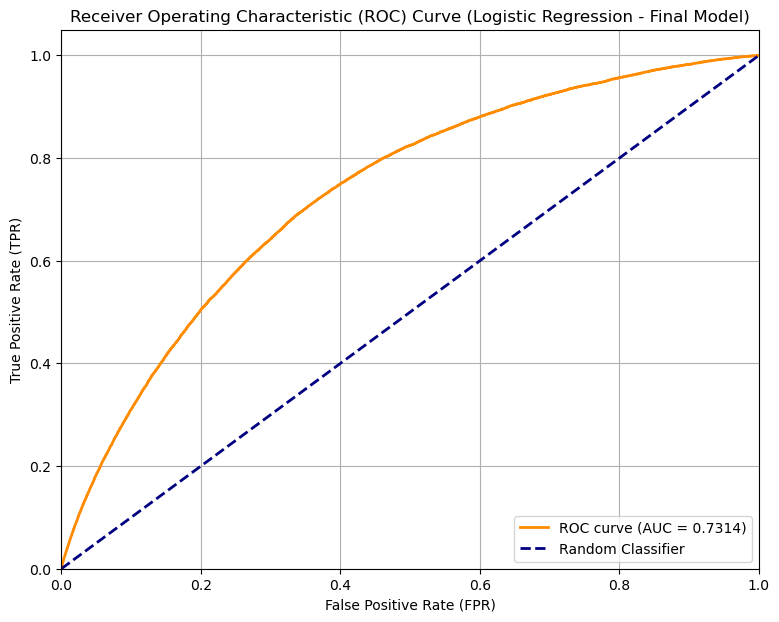

Значение ROC AUC на тестовой выборке: 0.7314


In [77]:
# --- 7. Построение ROC AUC кривой ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (Logistic Regression - Final Model)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Значение ROC AUC на тестовой выборке: {roc_auc:.4f}")

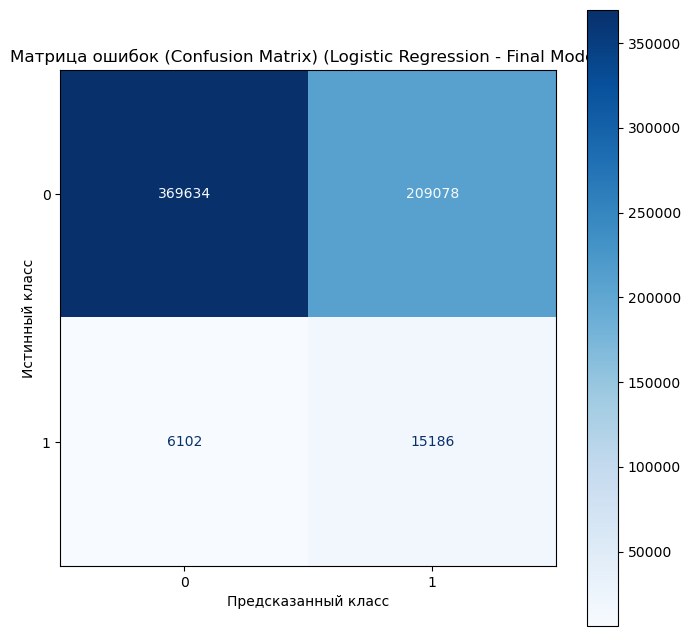


Матрица ошибок (Confusion Matrix):
 [[369634 209078]
 [  6102  15186]]


In [78]:
# --- 8. Построение матрицы ошибок (Confusion Matrix) ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_log_reg_model.classes_)

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title('Матрица ошибок (Confusion Matrix) (Logistic Regression - Final Model)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.grid(False)
plt.show()

print("\nМатрица ошибок (Confusion Matrix):\n", cm)

In [ ]:
# ПОСТРОИМ МОДЕЛЬ LightGBM

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV # Будем использовать GridSearchCV для примера, но RandomizedSearchCV также хорош.
from lightgbm import LGBMClassifier # Импортируем LightGBM
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [22]:
# Разделение данных на признаки (X) и целевую переменную (y)
features_to_drop = ['target']
if 'id' in train_data.columns:
    features_to_drop.append('id')

X = train_data.drop(columns=features_to_drop)
y = train_data['target']

In [23]:
# --- КЛЮЧЕВОЕ ИЗМЕНЕНИЕ 1: Приведение всех признаков к float32 ---
print(f"Исходный тип данных признаков: {X.dtypes.iloc[0]}")
X = X.astype(np.float32)
print(f"Новый тип данных признаков: {X.dtypes.iloc[0]} (уменьшено для экономии памяти)")

print(f"Размер X (признаков): {X.shape}")
print(f"Размер y (целевой переменной): {y.shape}")

# Разделение данных на обучающую и тестовую выборки
# LightGBM не требует масштабирования, но работаем с float32
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Размер X_test: {X_test.shape}, y_test: {y_test.shape}")

Исходный тип данных признаков: int8
Новый тип данных признаков: float32 (уменьшено для экономии памяти)
Размер X (признаков): (3000000, 420)
Размер y (целевой переменной): (3000000,)
Размер X_train: (2400000, 420), y_train: (2400000,)
Размер X_test: (600000, 420), y_test: (600000,)


In [24]:
# --- КЛЮЧЕВОЕ ИЗМЕНЕНИЕ 2: Создание подвыборки для GridSearchCV ---
# Для подбора гиперпараметров LightGBM на больших данных используем подвыборку.
subset_ratio = 0.1 # Использовать 10% обучающих данных для Grid Search

print(f"\nСоздаем подвыборку ({subset_ratio*100:.0f}%) обучающих данных для Grid Search...")
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, test_size=(1-subset_ratio), random_state=42, stratify=y_train
)
print(f"Размер X_train_subset для Grid Search: {X_train_subset.shape}")


# --- 3. Определение сетки для подбора гиперпараметров LightGBM ---
# Это лишь пример, для лучших результатов потребуется более тонкая настройка.
# Обратите внимание на `early_stopping_round`, он будет использоваться во время fit.
param_grid = {
    'n_estimators': [300, 500], # Количество деревьев. LightGBM может работать с большим числом, если есть early_stopping.
    'learning_rate': [0.05, 0.1], # Скорость обучения. Меньше learning_rate -> больше деревьев, но может дать лучшую точность.
    'num_leaves': [20, 31, 45],       # Количество листьев в дереве. Главный параметр контроля сложности.
    'max_depth': [-1, 10, 15],        # Максимальная глубина дерева. -1 означает неограниченную (контролируется num_leaves).
    'reg_alpha': [0, 0.1],        # L1 регуляризация
    'reg_lambda': [0, 0.1],       # L2 регуляризация
    'colsample_bytree': [0.7, 0.8], # Доля признаков для каждого дерева
    'subsample': [0.7, 0.8],      # Доля строк для каждого дерева (bagging)
    'class_weight': ['balanced']       # Для учета дисбаланса классов
}

print(f"\nСетка параметров для подбора: {param_grid}")



Создаем подвыборку (10%) обучающих данных для Grid Search...
Размер X_train_subset для Grid Search: (240000, 420)

Сетка параметров для подбора: {'n_estimators': [300, 500], 'learning_rate': [0.05, 0.1], 'num_leaves': [20, 31, 45], 'max_depth': [-1, 10, 15], 'reg_alpha': [0, 0.1], 'reg_lambda': [0, 0.1], 'colsample_bytree': [0.7, 0.8], 'subsample': [0.7, 0.8], 'class_weight': ['balanced']}


In [25]:
# --- 4. Инициализация LGBMClassifier и GridSearchCV ---
print("\nНачинаем подбор гиперпараметров LightGBM с помощью GridSearchCV на подвыборке...")

# Используем 'train_data' для передачи подвыборки, чтобы early_stopping_rounds работал корректно.
# eval_set нужен для early_stopping_rounds.
# `n_jobs=-1` для ускорения процесса кросс-валидации.
lgbm_classifier = LGBMClassifier(objective='binary',
                                 metric='auc',
                                 random_state=42,
                                 n_jobs=-1,
                                 # `early_stopping_round` задается при вызове .fit(), а не в конструкторе.
                                 # `verbose=-1` отключает вывод прогресса для каждого дерева,
                                 # но GridSearchCV сам управляет verbosity.
                                 verbose=-1)

# Определяем параметры для GridSearchCV
grid_search = GridSearchCV(estimator=lgbm_classifier,
                           param_grid=param_grid,
                           cv=3,
                           scoring='roc_auc',
                           verbose=3,
                           n_jobs=-1)

start_time = time.time()

# Запускаем поиск по сетке на ПОДВЫБОРКЕ данных
# Для корректной работы early_stopping_rounds, обычно нужно передать X_train_subset
# и y_train_subset в eval_set, но GridSearchCV сам разбивает данные на фолды.
# Так что просто передаем subset.
grid_search.fit(X_train_subset, y_train_subset)

end_time = time.time()
tuning_time = end_time - start_time

print(f"\nПодбор гиперпараметров LightGBM завершен. Время подбора: {tuning_time:.2f} секунд.")



Начинаем подбор гиперпараметров LightGBM с помощью GridSearchCV на подвыборке...
Fitting 3 folds for each of 576 candidates, totalling 1728 fits

Подбор гиперпараметров LightGBM завершен. Время подбора: 12944.41 секунд.


In [26]:
# --- 5. Обучение финальной модели на всем X_train ---
print("\nОбучаем финальную модель LightGBM на ВСЕМ обучающем наборе...")
best_params = grid_search.best_params_
print(f"Лучшие найденные параметры: {best_params}")
print(f"Лучший ROC AUC на кросс-валидации (по подвыборке): {grid_search.best_score_:.4f}")

final_lgbm_model = LGBMClassifier(objective='binary',
                                  metric='auc',
                                  random_state=42,
                                  n_jobs=-1,
                                  verbose=-1, # Отключаем verbose для финального обучения
                                  **best_params)

# Обучение финальной модели.
# В идеале, нужно выделить часть X_train как validation set для early_stopping.
# Для демонстрации, просто обучим с заданным n_estimators.
# Если в best_params есть n_estimators, оно будет использовано.
# Если бы мы хотели использовать early_stopping, нам нужен был бы eval_set.
# Например:
# X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)
# final_lgbm_model.fit(X_train_part, y_train_part,
#                      eval_set=[(X_val_part, y_val_part)],
#                      eval_metric='auc',
#                      callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]) # verbose=False, чтобы не спамить лог

start_time_final_train = time.time()
# Обучаем финальную модель на всем X_train (который уже float32)
final_lgbm_model.fit(X_train, y_train)
end_time_final_train = time.time()
final_training_time = end_time_final_train - start_time_final_train

print(f"Финальная модель LightGBM обучена на полном наборе данных. Время обучения: {final_training_time:.2f} секунд.")



Обучаем финальную модель LightGBM на ВСЕМ обучающем наборе...
Лучшие найденные параметры: {'class_weight': 'balanced', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 300, 'num_leaves': 20, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.7}
Лучший ROC AUC на кросс-валидации (по подвыборке): 0.7436
Финальная модель LightGBM обучена на полном наборе данных. Время обучения: 94.50 секунд.



Выполняем предсказания на тестовой выборке...


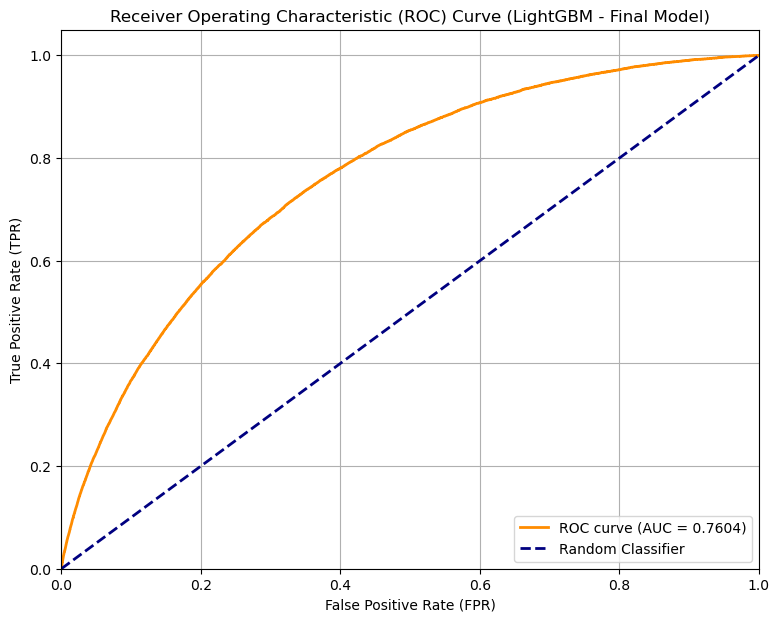

Значение ROC AUC на тестовой выборке: 0.7604


In [27]:
# --- 6. Прогнозирование на тестовой выборке (с лучшей моделью) ---
print("\nВыполняем предсказания на тестовой выборке...")
y_pred_proba = final_lgbm_model.predict_proba(X_test)[:, 1]
y_pred_default_threshold = final_lgbm_model.predict(X_test) # Предсказания с порогом 0.5

# --- 7. Построение ROC AUC кривой ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (LightGBM - Final Model)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Значение ROC AUC на тестовой выборке: {roc_auc:.4f}")



--- Оценка с порогом классификации по умолчанию (0.5) ---


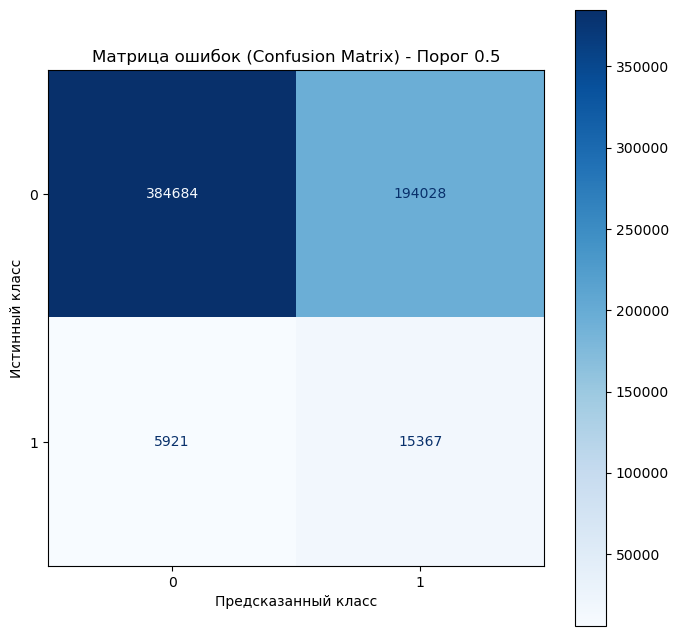


Матрица ошибок (Confusion Matrix) при пороге 0.5:
 [[384684 194028]
 [  5921  15367]]
Precision (для класса 1) при пороге 0.5: 0.0734
Recall (для класса 1) при пороге 0.5: 0.7219
F1-score (для класса 1) при пороге 0.5: 0.1332


In [28]:
# --- 8. Построение матрицы ошибок (Confusion Matrix) для порога по умолчанию (0.5) ---
print("\n--- Оценка с порогом классификации по умолчанию (0.5) ---")
cm_default = confusion_matrix(y_test, y_pred_default_threshold)
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=final_lgbm_model.classes_)

plt.figure(figsize=(8, 8))
disp_default.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title('Матрица ошибок (Confusion Matrix) - Порог 0.5')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.grid(False)
plt.show()

print("\nМатрица ошибок (Confusion Matrix) при пороге 0.5:\n", cm_default)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred_default_threshold, average='binary', pos_label=1)
print(f"Precision (для класса 1) при пороге 0.5: {precision:.4f}")
print(f"Recall (для класса 1) при пороге 0.5: {recall:.4f}")
print(f"F1-score (для класса 1) при пороге 0.5: {fscore:.4f}")

In [ ]:
#ПОСТРОИМ МОДЕЛЬ XGBoost

In [34]:
# Разделение данных на признаки (X) и целевую переменную (y)
from sklearn.model_selection import train_test_split, GridSearchCV
# Импортируем XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
# Разделение данных на признаки (X) и целевую переменную (y)
features_to_drop = ['target']
if 'id' in train_data.columns:
    features_to_drop.append('id')

X = train_data.drop(columns=features_to_drop)
y = train_data['target']

# --- КЛЮЧЕВОЕ ИЗМЕНЕНИЕ 1: Приведение всех признаков к float32 ---
print(f"Исходный тип данных признаков: {X.dtypes.iloc[0]}")
X = X.astype(np.float32)
print(f"Новый тип данных признаков: {X.dtypes.iloc[0]} (уменьшено для экономии памяти)")

print(f"Размер X (признаков): {X.shape}")
print(f"Размер y (целевой переменной): {y.shape}")

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Размер X_test: {X_test.shape}, y_test: {y_test.shape}")


# --- КЛЮЧЕВОЕ ИЗМЕНЕНИЕ 2: Создание подвыборки для GridSearchCV ---
subset_ratio = 0.1 # Использовать 10% обучающих данных для Grid Search

print(f"\nСоздаем подвыборку ({subset_ratio*100:.0f}%) обучающих данных для Grid Search...")
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, test_size=(1-subset_ratio), random_state=42, stratify=y_train
)
print(f"Размер X_train_subset для Grid Search: {X_train_subset.shape}")

Исходный тип данных признаков: int8
Новый тип данных признаков: float32 (уменьшено для экономии памяти)
Размер X (признаков): (3000000, 420)
Размер y (целевой переменной): (3000000,)
Размер X_train: (2400000, 420), y_train: (2400000,)
Размер X_test: (600000, 420), y_test: (600000,)

Создаем подвыборку (10%) обучающих данных для Grid Search...
Размер X_train_subset для Grid Search: (240000, 420)


In [35]:
# --- 3. Определение сетки для подбора гиперпараметров XGBoost ---
# Пример сетки. Может потребоваться более тонкая настройка.
param_grid = {
    'n_estimators': [300, 500], # Уменьшаем для скорости подбора
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5], # Уменьшаем глубину
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    # Расчет scale_pos_weight: count(negative_class) / count(positive_class)
    'scale_pos_weight': [20] # Примерное значение, подберите более точно под свои данные
}

print(f"\nСетка параметров для подбора: {param_grid}")


Сетка параметров для подбора: {'n_estimators': [300, 500], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'subsample': [0.7, 0.8], 'colsample_bytree': [0.7, 0.8], 'reg_alpha': [0, 0.1], 'reg_lambda': [0, 0.1], 'scale_pos_weight': [20]}


In [36]:
# --- 4. Инициализация XGBClassifier и GridSearchCV ---
print("\nНачинаем подбор гиперпараметров XGBoost с помощью GridSearchCV на подвыборке...")

# `use_label_encoder=False` для подавления предупреждений.
# `eval_metric='auc'` для оценки.
xgb_classifier = XGBClassifier(objective='binary:logistic',
                               eval_metric='auc',
                               use_label_encoder=False,
                               random_state=42,
                               n_jobs=-1) # Использовать все ядра CPU

grid_search = GridSearchCV(estimator=xgb_classifier,
                           param_grid=param_grid,
                           cv=3,
                           scoring='roc_auc',
                           verbose=3,
                           n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train_subset, y_train_subset) # Подбор на подвыборке
end_time = time.time()
tuning_time = end_time - start_time

print(f"\nПодбор гиперпараметров XGBoost завершен. Время подбора: {tuning_time:.2f} секунд.")# --- 4. Инициализация XGBClassifier и GridSearchCV ---



Начинаем подбор гиперпараметров XGBoost с помощью GridSearchCV на подвыборке...
Fitting 3 folds for each of 128 candidates, totalling 384 fits

Подбор гиперпараметров XGBoost завершен. Время подбора: 4420.04 секунд.


In [37]:
# --- 5. Обучение финальной модели на всем X_train с early_stopping_round ---
print("\nОбучаем финальную модель XGBoost на ВСЕМ обучающем наборе с early_stopping_round...")

best_params = grid_search.best_params_
print(f"Лучшие найденные параметры: {best_params}")
print(f"Лучший ROC AUC на кросс-валидации (по подвыборке): {grid_search.best_score_:.4f}")

# --- Разделяем X_train на обучающую и валидационную части ---
# Для ранней остановки обучения финальной модели
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train # 10% данных для валидации
)

print(f"\nРазделяем X_train на обучающую ({X_train_part.shape[0]}) и валидационную ({X_val_part.shape[0]}) части для early_stopping.")



Обучаем финальную модель XGBoost на ВСЕМ обучающем наборе с early_stopping_round...
Лучшие найденные параметры: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 0, 'scale_pos_weight': 20, 'subsample': 0.7}
Лучший ROC AUC на кросс-валидации (по подвыборке): 0.7463

Разделяем X_train на обучающую (2160000) и валидационную (240000) части для early_stopping.


In [38]:
# Инициализация финальной модели с найденными параметрами
final_xgb_model = XGBClassifier(objective='binary:logistic',
                                eval_metric='auc',
                                use_label_encoder=False,
                                random_state=42,
                                n_jobs=-1,
                                # Передаем early_stopping_rounds как параметр модели
                                early_stopping_rounds=100,
                                **best_params)

start_time_final_train = time.time()

# Обучение финальной модели
# eval_set используется для ранней остановки
final_xgb_model.fit(X_train_part, y_train_part,
                    eval_set=[(X_val_part, y_val_part)],
                    verbose=False) # verbose=False, чтобы не выводить прогресс для каждого шага

end_time_final_train = time.time()
final_training_time = end_time_final_train - start_time_final_train

print(f"Финальная модель XGBoost обучена. Время обучения: {final_training_time:.2f} секунд.")
# Получаем количество деревьев, на котором остановилась модель
print(f"Обучено деревьев: {final_xgb_model.best_iteration}")

Финальная модель XGBoost обучена. Время обучения: 246.53 секунд.
Обучено деревьев: 499


In [39]:
# --- 6. Прогнозирование на тестовой выборке (с лучшей моделью) ---
print("\nВыполняем предсказания на тестовой выборке...")
y_pred_proba = final_xgb_model.predict_proba(X_test)[:, 1]
# Делаем предсказания с порогом 0.5 (чтобы получить классы для Confusion Matrix)
y_pred_default_threshold = final_xgb_model.predict(X_test)



Выполняем предсказания на тестовой выборке...


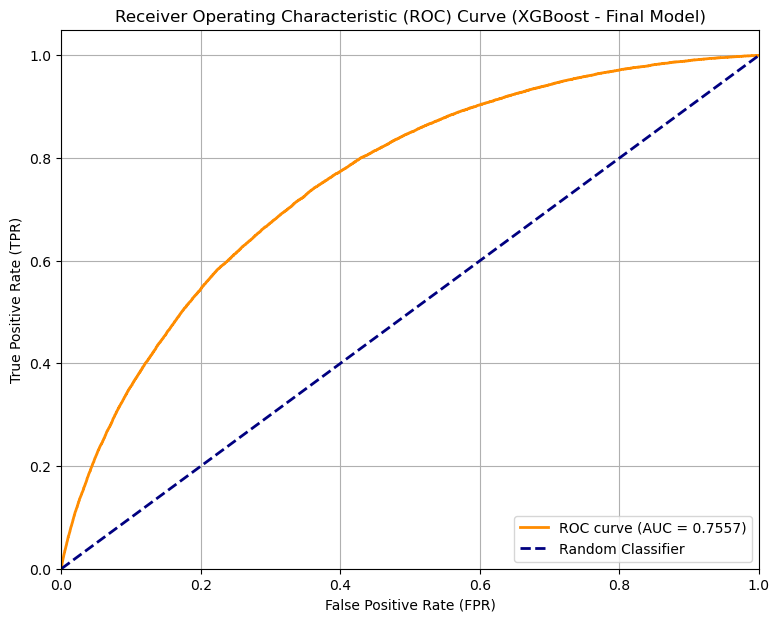

Значение ROC AUC на тестовой выборке: 0.7557


In [40]:
# --- 7. Построение ROC AUC кривой ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (XGBoost - Final Model)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Значение ROC AUC на тестовой выборке: {roc_auc:.4f}")


--- Оценка с порогом классификации по умолчанию (0.5) ---


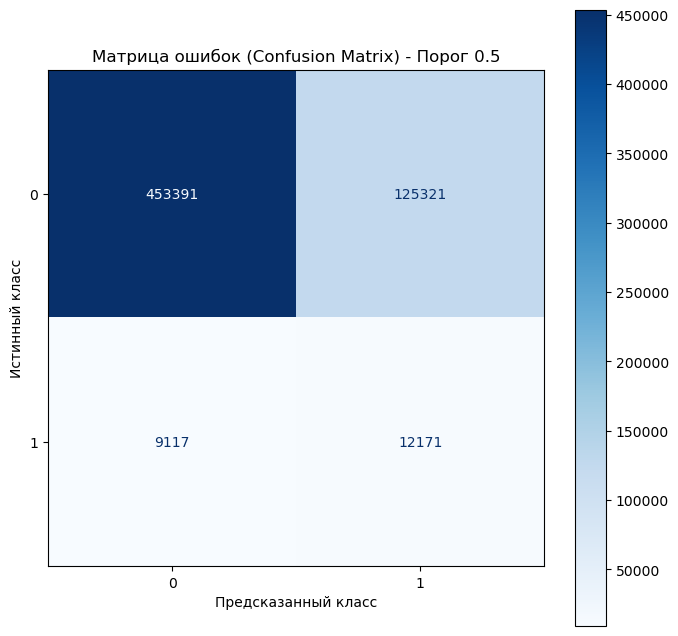


Матрица ошибок (Confusion Matrix) при пороге 0.5:
 [[453391 125321]
 [  9117  12171]]
Precision (для класса 1) при пороге 0.5: 0.0885
Recall (для класса 1) при пороге 0.5: 0.5717
F1-score (для класса 1) при пороге 0.5: 0.1533


In [41]:
# --- 8. Построение матрицы ошибок (Confusion Matrix) для порога по умолчанию (0.5) ---
print("\n--- Оценка с порогом классификации по умолчанию (0.5) ---")
cm_default = confusion_matrix(y_test, y_pred_default_threshold)
# Получаем метки классов из модели, если они были определены (обычно это 0 и 1)
# final_xgb_model.classes_ может быть недоступен, если он не установлен явно
# Но для бинарной классификации с 0 и 1 это обычно работает
try:
    display_labels = final_xgb_model.classes_
except AttributeError:
    display_labels = [0, 1] # Если classes_ недоступен, используем стандартные метки

disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=display_labels)

plt.figure(figsize=(8, 8))
disp_default.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title('Матрица ошибок (Confusion Matrix) - Порог 0.5')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.grid(False)
plt.show()

print("\nМатрица ошибок (Confusion Matrix) при пороге 0.5:\n", cm_default)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred_default_threshold, average='binary', pos_label=1)
print(f"Precision (для класса 1) при пороге 0.5: {precision:.4f}")
print(f"Recall (для класса 1) при пороге 0.5: {recall:.4f}")
print(f"F1-score (для класса 1) при пороге 0.5: {fscore:.4f}")

Вывод:В ходе проделанной работы произведено итеративное чтение большого объёма данных, собран итоговый датафрейм, состоящий из признаков для обучения модели. После обучения модели, были получены следующие метрики качества:
1) Модель CatBoost: ROC AUC = 0.7559
2) Модель CatBoost (подбор по сетке): ROC AUC = 0.759
3) Модель LogisticRegression: ROC AUC = 0.7314
4) Модель LightGBM: ROC AUC = 0.7604
5) Модель XGBoost: ROC AUC = 0.7557